In [1]:
import sys
sys.path.insert(0, '/home/andy/CovidDepressionAnalysis/scripts/data_processing')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

import pickle as pkl

from scipy import stats
from sklearn.decomposition import PCA
import seaborn as sns
from constants import *



In [2]:
class LongitudinalAnalysis():
    def __init__(self, shrink=True):
        with open('../output/v3_python/full_imputed.pickle', 'rb') as f:
            imputed = pkl.load(f)

        if shrink == True:
            self.data = imputed['data'][:,:,1:13]
            self.waves = [x for x in range(2,14)]
            self.weeks = [wave_weeks[x] for x in self.waves]
        else:
            self.data = imputed['data']
            self.waves = [x for x in range(1, imputed['data'].shape[2]+1)]
            self.weeks = [wave_weeks[x] for x in self.waves]
        self.columns = imputed['columns']
        self.ids = imputed['cvdids']

        self.index_bdi = imputed['columns'].index('BDI')
        self.index_sah = imputed['columns'].index('Mandatory_SAH')

        self.sah_variability = []

        for i in range(self.data.shape[0]):
            indexes = np.array(self.data[i, imputed['columns'].index('Mandatory_SAH'),:], dtype=bool)
            if ~((indexes == 1).all() | (indexes == 0).all()):
                self.sah_variability.append(True)

    def compare_before_after_sah(self, data):
        before_sah = []
        after_sah = []
        for i in range(data.shape[0]):
            for j in range(data.shape[2]):
                if data[i, self.index_sah, j] == 1:
                    after_sah.append(data[i, self.index_bdi, j])
                else:
                    before_sah.append(data[i, self.index_bdi, j])
        return before_sah, after_sah
    
    def pearson_corr(self, x1, x2):
        return (stats.ttest_ind(x1, x2))
    
    def corr_m(self, m1, m2):
        corr_out = []
        pval_out = []

        for i in range(self.data.shape[0]):
            pearson_corr = stats.pearsonr(m1[i,:], m2[i,:])
            corr_out.append(pearson_corr[0])
            pval_out.append(pearson_corr[1])

        df = pd.DataFrame({'corr':corr_out, 'pval':pval_out})
        return df
    
    def corr(self, var1, var2):
        corr_out = []
        pval_out = []

        index_var1 = self.columns.index(var1)
        index_var2 = self.columns.index(var2)

        for i in range(self.data.shape[0]):
            m_var1 = self.data[i, index_var1, :]
            m_var2 = self.data[i, index_var2, :]
            pearson_corr = stats.pearsonr(m_var1, m_var2)
            corr_out.append(pearson_corr[0])
            pval_out.append(pearson_corr[1])

        df = pd.DataFrame({'corr':corr_out, 'pval':pval_out})
        return df
    
    def bdi_sah_corr(self):
        corr_out = []
        pval_out = []
        for i in range(self.data.shape[0]):
            BDI = self.data[i, self.index_bdi, :]
            SAH = self.data[i, self.index_sah, :]
            pearson_corr = stats.pearsonr(BDI, SAH)
            corr_out.append(pearson_corr[0])
            pval_out.append(pearson_corr[1])

        df = pd.DataFrame({'corr':corr_out, 'pval':pval_out})
        return df
    
    def extract_significant_subjects(self, df):
        significant_positive_indexes = ((df['pval'] < 0.05) & (df['corr'] > 0)).values
        significant_negative_indexes = ((df['pval'] < 0.05) & (df['corr'] < 0)).values
        
        neutral_indexes = (~df['corr'].isna()) & (~(significant_positive_indexes | significant_negative_indexes))
        return significant_positive_indexes, significant_negative_indexes, neutral_indexes
    

    def get_columns(self, columns):
        indexes = []
        for i in range(len(columns)):
            indexes.append(self.columns.index(columns[i]))

        return self.data[:, indexes,:]
    
    def plot_columns_with_groups(self, columns, groups):
        df = pd.DataFrame(columns=columns, data=np.mean(self.get_columns(columns), 2))
        df['group'] = groups

        df = df.melt(id_vars=['group'], value_vars=columns)

        sns.barplot(data=df, x='variable', y='value', hue='group')
        
    def subject_classification(self, positive_indexes, negative_indexes, neutral_indexes):
        cls = []
        for i in range(len(positive_indexes)):
            if positive_indexes[i] == True:
                cls.append('positive')
            elif negative_indexes[i] == True:
                cls.append('negative')
            elif neutral_indexes[i] == True:
                cls.append('neutral')
            else:
                cls.append('NA')
        return cls

    def plot_personality_3d(self, columns, c):

        personality = self.extract_columns(columns)
        print(personality.shape)
        x = np.mean(personality[:,0,:], axis=1)
        y = np.mean(personality[:,1,:], axis=1)
        z = np.mean(personality[:,2,:], axis=1)
        
        # Creating figure
        fig = plt.figure(figsize = (10, 7))
        ax = plt.axes(projection ="3d")
        
        print(personality[:,0].shape)

        # Creating plot
        ax.scatter(x, y, z, c=c)
        plt.title("simple 3D scatter plot")

        plt.legend()
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_zlim(0, 1)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        
        # show plot
        plt.show()

    def detect_change(self, subset=None):

        if subset is None:
            data = self.data
        else:
            data = self.data[subset,:,:]

        SAH = data[:,self.index_sah,:]
        before_bdi = []
        after_bdi = []
        NEO_Neuroticism = []
        NEO_Extraversion = []
        NEO_Openness = [] 
        NEO_Agreeableness = [] 
        NEO_Conscientiousness = []

        for i in range(SAH.shape[0]):
            for j in range(SAH.shape[1]-1):
                if (SAH[i, j] == 1) & (SAH[i, j+1] == 0):
                    before_bdi.append(data[i, self.index_bdi, j])
                    after_bdi.append(data[i, self.index_bdi, j+1])
                    NEO_Neuroticism.append(data[i, self.columns.index('NEO_Neuroticism'), j])
                    NEO_Extraversion.append(data[i, self.columns.index('NEO_Extraversion'), j])
                    NEO_Openness.append(data[i, self.columns.index('NEO_Openness'), j])
                    NEO_Agreeableness.append(data[i, self.columns.index('NEO_Agreeableness'), j])
                    NEO_Conscientiousness.append(data[i, self.columns.index('NEO_Conscientiousness'), j])

        df = pd.DataFrame(columns=['before_sah_bdi','after_sah_bdi', 'NEO_Neuroticism', 'NEO_Extraversion', 'NEO_Openness', 'NEO_Agreeableness', 'NEO_Conscientiousness'], 
                          data=np.vstack([before_bdi, after_bdi, NEO_Neuroticism, NEO_Extraversion, NEO_Openness, NEO_Agreeableness, NEO_Conscientiousness]).T)

        return df
    
    def test_correlation(self, column):
        corrs = []
        pvals = []
        for i in range(self.data.shape[0]):
            index = self.columns.index(column)
            column_val = self.data[i, index, :]
            BDI = self.data[i, self.index_bdi, :]
            corr = stats.pearsonr(column_val, BDI)
            corrs.append(corr[0])
            pvals.append(corr[1])

        df = pd.DataFrame({'corr': corrs, 'pval': pvals})
        df['significance'] = df['pval'] < 0.05
        df['positive'] = df['corr'] > 0
        return df
    


# Questions

1. The changes of personality
2. Does the 3 classes classification make sense?
3. What are the other things that we should try?
4. Do the linear mixed effect model make sense?
5. Predictability of personality for the classes identified (0.6 F1 score).
6. Where should we send this too?



# 

# Plot BDI for different personality scores, groups looking at correlation between SAH and BDI

The idea of this analysis is to look at whether longitudinally whether mandatory stay-at-home orders have a correlation with BDI score. We can look at this in two different levels - group level and individual level

In [121]:
# Inititate the analysis object that contains the data and the analysis functions.
analysis = LongitudinalAnalysis()

## 1. group level

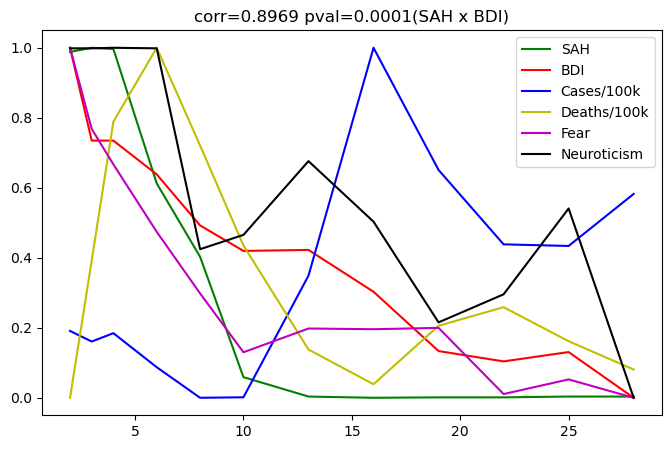

In [122]:
# Look at longitudinal correlation between Mandatory stay-at-home orders and BDI at the group level

case_indexes = analysis.columns.index('cases_avg_per_100k')
death_indexes = analysis.columns.index('deaths_avg_per_100k')
fear_indexes = analysis.columns.index('Fear')
neuroticism_indexes = analysis.columns.index('NEO_Neuroticism')

SAH = np.mean(analysis.data[:, analysis.index_sah, :], axis=0)
BDI = np.mean(analysis.data[:, analysis.index_bdi, :], axis=0)
cases = np.mean(analysis.data[:, case_indexes, :], axis=0)
deaths = np.mean(analysis.data[:, death_indexes, :], axis=0)
fear = np.mean(analysis.data[:, fear_indexes, :], axis=0)
neuroticism = np.mean(analysis.data[:, neuroticism_indexes, :], axis=0)

corr = np.round(stats.pearsonr(SAH, BDI), 4)

fig = plt.figure(figsize = (8, 5))

plt.plot(analysis.weeks, (SAH-np.min(SAH))/(np.max(SAH)-np.min(SAH)), c='g')
plt.plot(analysis.weeks, (BDI-np.min(BDI))/(np.max(BDI)-np.min(BDI)), c='r')
plt.plot(analysis.weeks, (cases-np.min(cases))/(np.max(cases)-np.min(cases)), c='b')
plt.plot(analysis.weeks, (deaths-np.min(deaths))/(np.max(deaths)-np.min(deaths)), c='y')
plt.plot(analysis.weeks, (fear-np.min(fear))/(np.max(fear)-np.min(fear)), c='m')
plt.plot(analysis.weeks, (neuroticism-np.min(neuroticism))/(np.max(neuroticism)-np.min(neuroticism)), c='black')

plt.title('corr='+str(corr[0]) + ' pval='+str(corr[1]) + '(SAH x BDI)')
plt.legend(['SAH', 'BDI', 'Cases/100k', 'Deaths/100k', 'Fear', 'Neuroticism'])


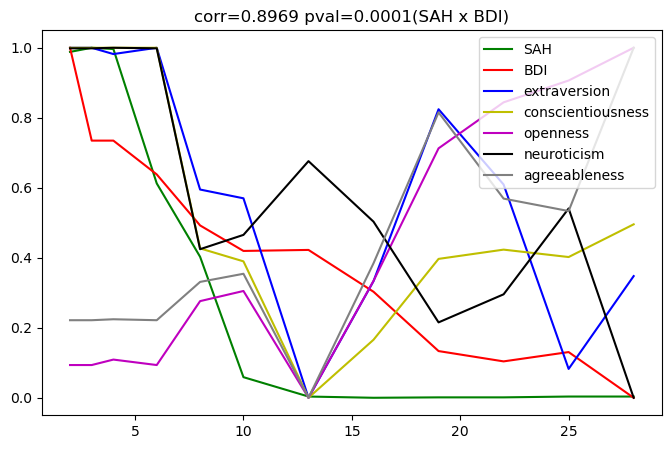

In [123]:
# Look at longitudinal correlation between Mandatory stay-at-home orders and BDI at the group level

case_indexes = analysis.columns.index('cases_avg_per_100k')
death_indexes = analysis.columns.index('deaths_avg_per_100k')
fear_indexes = analysis.columns.index('Fear')
neuroticism_indexes = analysis.columns.index('NEO_Neuroticism')
openness_indexes = analysis.columns.index('NEO_Openness')
conscientiousness_indexes = analysis.columns.index('NEO_Conscientiousness')
extraversion_indexes = analysis.columns.index('NEO_Extraversion')
agreeableness_indexes = analysis.columns.index('NEO_Agreeableness')

SAH = np.mean(analysis.data[:, analysis.index_sah, :], axis=0)
BDI = np.mean(analysis.data[:, analysis.index_bdi, :], axis=0)

neuroticism = np.mean(analysis.data[:, neuroticism_indexes, :], axis=0)
openness = np.mean(analysis.data[:, openness_indexes, :], axis=0)
conscientiousness = np.mean(analysis.data[:, conscientiousness_indexes, :], axis=0)
extraversion = np.mean(analysis.data[:, extraversion_indexes, :], axis=0)
agreeableness = np.mean(analysis.data[:, agreeableness_indexes, :], axis=0)

corr = np.round(stats.pearsonr(SAH, BDI), 4)

fig = plt.figure(figsize = (8, 5))

plt.plot(analysis.weeks, (SAH-np.min(SAH))/(np.max(SAH)-np.min(SAH)), c='g')
plt.plot(analysis.weeks, (BDI-np.min(BDI))/(np.max(BDI)-np.min(BDI)), c='r')
plt.plot(analysis.weeks, (extraversion-np.min(extraversion))/(np.max(extraversion)-np.min(extraversion)), c='b')
plt.plot(analysis.weeks, (conscientiousness-np.min(conscientiousness))/(np.max(conscientiousness)-np.min(conscientiousness)), c='y')
plt.plot(analysis.weeks, (openness-np.min(openness))/(np.max(openness)-np.min(openness)), c='m')
plt.plot(analysis.weeks, (neuroticism-np.min(neuroticism))/(np.max(neuroticism)-np.min(neuroticism)), c='black')
plt.plot(analysis.weeks, (agreeableness-np.min(agreeableness))/(np.max(agreeableness)-np.min(agreeableness)), c='gray')

plt.title('corr='+str(corr[0]) + ' pval='+str(corr[1]) + '(SAH x BDI)')
plt.legend(['SAH', 'BDI', 'extraversion', 'conscientiousness', 'openness', 'neuroticism', 'agreeableness'])


In [124]:
np.mean(analysis.data[:, analysis.columns.index('NEO_Conscientiousness'), analysis.waves.index(8)])




0.6804021523647692

In [125]:
np.mean(analysis.data[:, analysis.columns.index('NEO_Openness'), analysis.waves.index(8)])

0.6426384168790711

In [126]:
stats.pearsonr(SAH, BDI)

PearsonRResult(statistic=0.896923399990559, pvalue=7.690292840681623e-05)

This shows that on average, BDI is positively correlated with SAH at the group-level, and it's negatively correlated with Covid cases. Although the positive correlation on average might reflect a general tendency that as time goes on, the public has accepted the new life style that Covid has brought to and therefore they become less depressed. The correlation is likely to be spurious because they are likely driven by other factors.

It makes sense that mandatory SAH has a negative correlation with Covid cases because when the restriction is lifed, Covid cases started to rise. And the dynamic of deaths is interesting, because as time goes on, the number of deaths decreases and then it started to rise again after wave 12. From here (https://en.wikipedia.org/wiki/Timeline_of_the_SARS-CoV-2_Omicron_variant#:~:text=This%20timeline%20of%20the%20SARS,and%2For%20discovered%20in%20retrospect.) The surge of Covid cases and deaths after wave 12 (September) is very likely due to the Omicron virus. I am tempting to even only focus on the analysis between wave 5 and wave 12, or at least take into account the Omicron variant.

The impact of Omicron actually forces some states to go back into mandatory stay at home orders (wave 12 to wave 15). I could potentially look at those states and see the impact the mandatory stay-at-home orders - this might actually be an opportunity for the synthetic control method.

Another thought about mandatory stay-at-home orders is that Covid cases might not be the main drving factor whether a county is under restriction or not. It might actually more depend on Covid deaths. It might also depend on time changes and dynamics of the environment, such as perception of Covid, economic factors and availability of preventative strategies (e.g., vaccines). We can see that fear of Covid (purple) is always decreasing and it is highly correlated with the BDI score (red), and the decreasing trend does not depend of the surge of Covid cases and death because of Omicron.
 

## 2. Individual level

### 1. Heterogeneity in correlations between BDI and SAH

In the individual level, we would like to see how many subjects are postively/negatively correlated with mandatory stay-at-home orders. From the individual level, we might be able to uncover individual heterogeneity for their responses to SAH.

/home/andy/anaconda3/envs/g/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Text(0.5, 1.0, 'n_vary=859 n_positive=224(0.26) n_negative=110(0.13)')

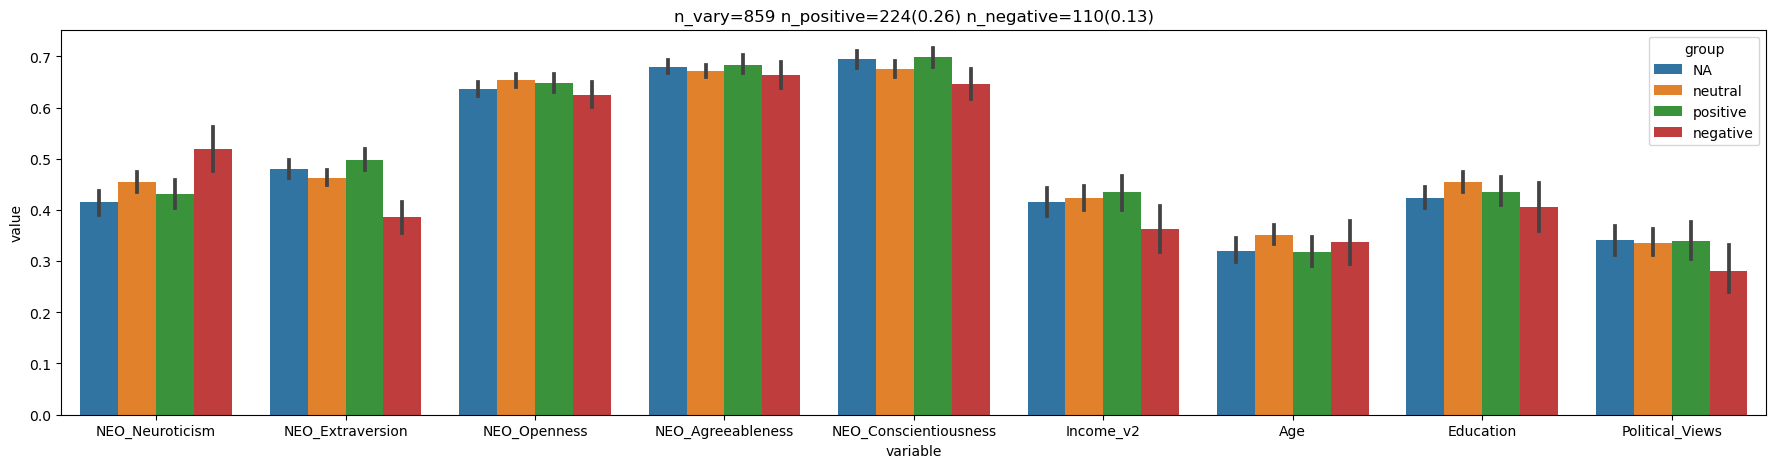

In [127]:
# The variables for heterogeneity:
vars = ["NEO_Neuroticism", 
        "NEO_Extraversion", 
        "NEO_Openness", 
        "NEO_Agreeableness", 
        "NEO_Conscientiousness",
        "Income_v2",
        "Age",
        "Education",
        "Political_Views"]

# Get subject indexes that are postively/negatively correlated with SAH
corr_df = analysis.bdi_sah_corr()
positive_indexes, negative_indexes, neutral_indexes = analysis.extract_significant_subjects(corr_df)
cls = analysis.subject_classification(positive_indexes, negative_indexes, neutral_indexes)
# The differences in the three different groups of people identified.

fig = plt.figure(figsize = (22, 5))
analysis.plot_columns_with_groups(vars, cls)

positive_percentage = np.round(np.sum(positive_indexes)/np.sum(analysis.sah_variability),2)
negative_percentage = np.round(np.sum(negative_indexes)/np.sum(analysis.sah_variability),2)

plt.title('n_vary='+str(np.sum(analysis.sah_variability)) + ' n_positive='+str(np.sum(positive_indexes)) + '({})'.format(str(positive_percentage)) + ' n_negative='+str(np.sum(negative_indexes)) + '({})'.format(str(negative_percentage)))

The first thing to think about is the numbers of people who are uncovered as having negative vs positive correlation between BDI and SAH. Among 860 people who have experience any changes in mandatory stay-at-home orders, 237 (28%) of them have positive correlation, while 120 (14%) of them have negative correlation. The percentages are significantly higher than chance (although we might need to think about multiple comparisons).  

By looking at the Big-Five personality scores, income level, age, education and political views, we can see that neuroticism, extraversion, conscientiousness and income have significant segregation for the the negative and positive groups. The people in group with negative correlation, who tend to have higher depression score after the restrictions were lifted, are more neurotic, more introvert, less conscientious, and have less income.

The group of people with positive correlation between BDI and SAH does not seem to be having significant different compared to the neutral group. The positive correlation might be driven by something else or a complex non-linear combination of these variables.

The interesting thing about this is that this reflects a correlation between BDI and SAH. So longitudinally among individuals they are not independent from each other. There is a group of people with some characteristics that are negatively correlated with SAH. When the goverment did lift SAH, some people are more depressed and they are people with higher are more neurotic, more introvert, less conscientious, and have less income. 

The positive correlation might actually be a bit more suspecious, because we actually detect a average positive correlation between SAH and BDI, which means that these individuals with positive correlation might actually due to spurious correlation, such as the general perception of Covid (Fear). So these people are generally happier to get back to normal. Although, we were not able to identify a difference in terms of the big-five and other variables. 

But still, if this is some real correlation, we would also expect to find this effect in the cross-sectional study. But somehow we don't seem to find this general trend among all the subjects, at least we don't have enough evidence to conclude in the cross-sectional studes. But, I think that using the group of people that we identify as having positive correlation, we might be able to find the correlation.

Something that I think we could try is to run some Generalized linear mixed effect models, with a time + time squaired variable, mandatory SAH, and the three group of people that we identified, and it's iteraction terms. From this generalized linear mixed effect model (https://towardsdatascience.com/generalized-linear-mixed-effects-models-in-r-and-python-with-gpboost-89297622820c), we might be able to identify the effect of the step function. In this model, we could potentially include variables that could be confounders - Covid cases and deaths.

So what I can do is to try generalized linear mixed effect model to assess the effect of mandatory stay-at-home orders. The random effect is the three different groups of people that we identify as negative, positive and neutral correlation between BDI and SAH. Another random effect model can be just having each subject as an independent group. Then I can use time as a fixed effect variable + a potential confounder Covid cases and deaths per 100k. I guess this could be a very good model to see whether we identify a significant effect interms of random effects x mandatory SAH.

In [74]:
before_sah = []
after_sah = []
SAH = analysis.data[:,analysis.index_sah,:]

for i in range(SAH.shape[0]):

    if (len(np.unique(analysis.data[i,analysis.index_sah,:])) == 2):
        indexes = np.array(SAH[i, :], dtype=bool)

        mean_bdi_sah1 = np.mean(analysis.data[i, analysis.index_bdi, indexes])
        mean_bdi_sah0 = np.mean(analysis.data[i, analysis.index_bdi, ~indexes])
        before_sah.append(mean_bdi_sah1)
        after_sah.append(mean_bdi_sah0)

print(len(before_sah))
print(stats.ttest_ind(before_sah, after_sah))
print(np.mean(before_sah))
print(np.mean(after_sah))


859
Ttest_indResult(statistic=0.8442710690092403, pvalue=0.39863563170116345)
0.1977879307436101
0.19089605598004067


In [75]:

before_sah = []
after_sah = []
SAH = analysis.data[positive_indexes,analysis.index_sah,:]
positive_data = analysis.data[positive_indexes,:,:]

print(SAH.shape)

for i in range(SAH.shape[0]):

    if (len(np.unique(positive_data[i,analysis.index_sah,:])) == 2):
        indexes = np.array(SAH[i, :], dtype=bool)
        mean_bdi_sah1 = np.mean(positive_data[i, analysis.index_bdi, indexes])
        mean_bdi_sah0 = np.mean(positive_data[i, analysis.index_bdi, ~indexes])
        before_sah.append(mean_bdi_sah1)
        after_sah.append(mean_bdi_sah0)

print(len(before_sah))
print(stats.ttest_ind(before_sah, after_sah))
print(np.mean(before_sah))
print(np.mean(after_sah))

(224, 12)
224
Ttest_indResult(statistic=4.4524250708384265, pvalue=1.0743238931306544e-05)
0.20820621177764037
0.14511688776941753


In [76]:

before_sah = []
after_sah = []
SAH = analysis.data[negative_indexes,analysis.index_sah,:]
negative_data = analysis.data[negative_indexes,:,:]

print(SAH.shape)

for i in range(SAH.shape[0]):

    if (len(np.unique(negative_data[i,analysis.index_sah,:])) == 2):
        indexes = np.array(SAH[i, :], dtype=bool)
        mean_bdi_sah1 = np.mean(negative_data[i, analysis.index_bdi, indexes])
        mean_bdi_sah0 = np.mean(negative_data[i, analysis.index_bdi, ~indexes])
        before_sah.append(mean_bdi_sah1)
        after_sah.append(mean_bdi_sah0)

print(len(before_sah))
print(stats.ttest_ind(before_sah, after_sah))
print(np.mean(before_sah))
print(np.mean(after_sah))

(110, 12)
110
Ttest_indResult(statistic=-2.6403194505353635, pvalue=0.00888169443384321)
0.22843314093314093
0.2980024164547974


### 1.5 Predicting the three different classes using the personality scores from wave 1

In [77]:
vars = ["NEO_Neuroticism", 
        "NEO_Extraversion", 
        "NEO_Openness", 
        "NEO_Agreeableness", 
        "NEO_Conscientiousness"]

big_five_data = analysis.get_columns(vars)[:, :, 0]

y = np.copy(positive_indexes).astype(int)
y[negative_indexes] = -1
y[~(positive_indexes | negative_indexes)] = 0



In [15]:
import statsmodels.api as sm
X = sm.add_constant(big_five_data)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     4.717
Date:                Tue, 18 Apr 2023   Prob (F-statistic):           0.000285
Time:                        10:44:49   Log-Likelihood:                -897.31
No. Observations:                1177   AIC:                             1807.
Df Residuals:                    1171   BIC:                             1837.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1797      0.146     -1.232      0.2

In [16]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

# Create a Random Forest regressor with 100 trees
regr = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(regr, big_five_data, y, cv=5, scoring='r2')

# Print the R-squared scores for each fold
print("R-squared scores for each fold:", cv_scores)

# Calculate the mean and standard deviation of the R-squared scores
mean_r2 = cv_scores.mean()
std_r2 = cv_scores.std()

# Print the mean and standard deviation of the R-squared scores
print("Mean R-squared score: {:.2f}".format(mean_r2))
print("Standard deviation of R-squared score: {:.2f}".format(std_r2))


R-squared scores for each fold: [-0.07619555 -0.03939217 -0.01735051 -0.17017664 -0.14583641]
Mean R-squared score: -0.09
Standard deviation of R-squared score: 0.06


In [17]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, make_scorer


# Create a logistic regression model
log_reg = LogisticRegression(random_state=42)

# Create an F1 score scorer
f1_scorer = make_scorer(f1_score, average='weighted')

# Perform 5-fold cross-validation
cv_scores = cross_val_score(log_reg, big_five_data, y, cv=5, scoring=f1_scorer)

# Print the F1 scores for each fold
print("F1 scores for each fold:", cv_scores)

# Calculate the mean and standard deviation of the F1 scores
mean_f1 = cv_scores.mean()
std_f1 = cv_scores.std()

# Print the mean and standard deviation of the F1 scores
print("Mean F1 score: {:.2f}".format(mean_f1))
print("Standard deviation of F1 score: {:.2f}".format(std_f1))

F1 scores for each fold: [0.59763549 0.59763549 0.60166421 0.59604034 0.59604034]
Mean F1 score: 0.60
Standard deviation of F1 score: 0.00


F1 = 2 * (precision * recall) / (precision + recall)

The F1 score ranges from 0 to 1, where a score of 0 indicates the worst possible performance and a score of 1 indicates perfect performance. A high F1 score indicates that the classifier has both high precision and high recall. In other words, it is a balanced measure of the model's ability to correctly identify positive instances while minimizing false positives.

When dealing with multi-class classification problems, the F1 score can be calculated for each class individually and then averaged using either the "macro" or "weighted" method:

Macro-average F1 score: Calculate the F1 score for each class independently and then average them. This method treats all classes as equally important, regardless of their frequency in the dataset.
Weighted-average F1 score: Calculate the F1 score for each class independently and then compute the average, weighted by the number of samples in each class. This method takes the class imbalance into account, giving more importance to the more frequent classes.


### 2. Heterogeneity in correlations between BDI and Covid Cases

/home/andy/anaconda3/envs/g/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


161
169


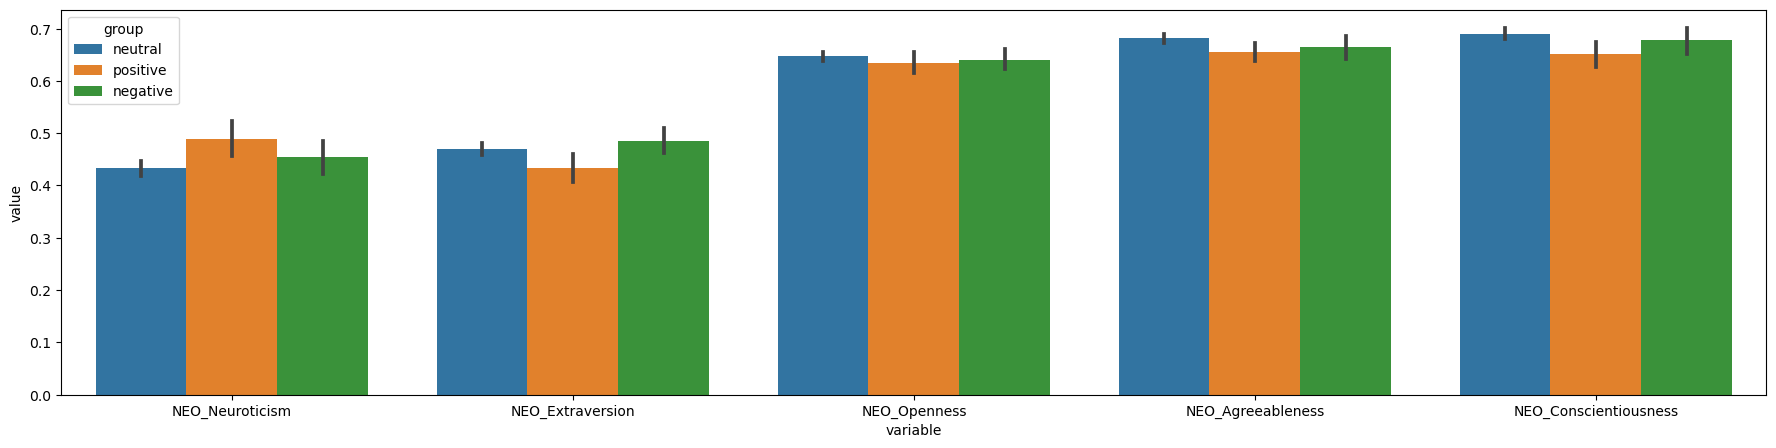

In [18]:
covid_related_variables = ['cases_avg',
                        'deaths_avg',
                        'cases_avg_per_100k',
                        'deaths_avg_per_100k']

# X = analysis.get_columns(covid_related_variables)

# pca_transformed = np.zeros((X.shape[0], X.shape[2]))

# for i in range(X.shape[2]):
#     pca = PCA(n_components=1, svd_solver='full')
#     pca.fit(X[:,:,i])
#     pca_covid_severity = np.squeeze(pca.transform(X[:,:,i]))
#     pca_transformed[:,i] = pca_covid_severity



BDI = analysis.data[:, analysis.index_bdi, :]
covid_cases = analysis.data[:, analysis.columns.index('cases_avg_per_100k'), :]

positive_indexes, negative_indexes = analysis.extract_significant_subjects(analysis.corr_m(BDI, covid_cases))

print(np.sum(positive_indexes))
print(np.sum(negative_indexes))

cls = analysis.subject_classification(positive_indexes, negative_indexes)
fig = plt.figure(figsize = (22, 5))
analysis.plot_columns_with_groups(vars, cls)


### 3. Heterogeneity in correlations between BDI and Covid deaths



/home/andy/anaconda3/envs/g/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


131
135


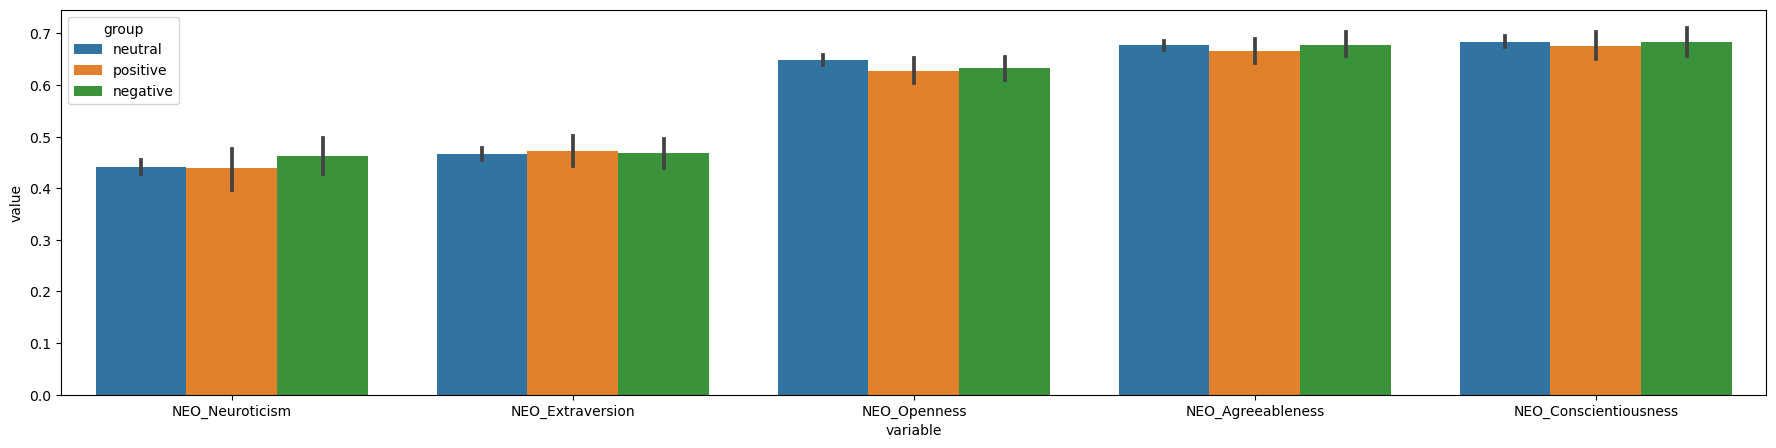

In [19]:
covid_related_variables = ['cases_avg',
                        'deaths_avg',
                        'cases_avg_per_100k',
                        'deaths_avg_per_100k']

# X = analysis.get_columns(covid_related_variables)

# pca_transformed = np.zeros((X.shape[0], X.shape[2]))

# for i in range(X.shape[2]):
#     pca = PCA(n_components=1, svd_solver='full')
#     pca.fit(X[:,:,i])
#     pca_covid_severity = np.squeeze(pca.transform(X[:,:,i]))
#     pca_transformed[:,i] = pca_covid_severity



BDI = analysis.data[:, analysis.index_bdi, :]
covid_deaths = analysis.data[:, analysis.columns.index('deaths_avg_per_100k'), :]

positive_indexes, negative_indexes = analysis.extract_significant_subjects(analysis.corr_m(BDI, covid_deaths))

print(np.sum(positive_indexes))
print(np.sum(negative_indexes))

cls = analysis.subject_classification(positive_indexes, negative_indexes)
fig = plt.figure(figsize = (22, 5))
analysis.plot_columns_with_groups(vars, cls)


### 4. Generalized linear mixed effect models

Longitudinal analysis on individuals basically rules out the possibility of arrows pointing 

In [20]:
from pymer4.models import Lmer

data = pd.read_csv('../output/jasp/all.csv', index_col=0)
data.head()



,Race_A,Race_AA,Race_W,Gender,Political_Views,Age,Education,Income,Income_v2,BDI,...,cases_avg_per_100k,deaths_avg_per_100k,slope_new_cases,slope_new_deaths,lat,lng,population,Mandatory_SAH,wave,ids
0,0.0,0.0,1.0,0.0,0.083333,0.578125,0.500,0.4,0.571429,0.253968,...,0.001169,0.000000,0.546209,0.379953,0.486497,0.397570,0.004189,1.0,2,2
1,0.0,0.0,1.0,0.0,0.000000,0.718750,0.500,0.4,0.571429,0.079365,...,0.008680,0.004777,0.550796,0.383450,0.519114,0.767834,0.055232,1.0,2,3
2,0.0,0.0,0.0,1.0,0.500000,0.078125,0.000,0.0,0.000000,0.523810,...,0.010613,0.003185,0.546209,0.379953,0.297191,0.462466,0.328839,1.0,2,4
3,0.0,0.0,1.0,0.0,0.833333,0.453125,0.125,0.0,0.000000,0.000000,...,0.013447,0.006369,0.546209,0.379953,0.337163,0.468688,0.216511,1.0,2,6
4,0.0,0.0,1.0,0.0,0.500000,0.468750,0.250,0.0,0.285714,0.412698,...,0.002923,0.000000,0.545413,0.371795,0.588257,0.395998,0.010708,1.0,2,7


In [21]:
#calculate interquartile range for psychological - outlier detection
vars = ["Fear", "NEO_Extraversion", "NEO_Neuroticism", "NEO_Conscientiousness", "NEO_Agreeableness",
        "NEO_Openness"]

index_dict = {}
index_ls = []

for var in vars:
    index_dict[var] = {}
    w_data = data.loc[:, var].values
    q3, q1 = np.percentile(w_data, [75 ,25])
    IQR = q3-q1
    test_interquantile = (w_data < (q1-1.5*IQR)) | (w_data > q3+1.5*IQR)
    if(test_interquantile.any()):
        index_dict[var] = test_interquantile
        index_ls.append(test_interquantile)

index_ls = np.vstack(index_ls)    
selection = index_ls.any(axis=0)
np.unique(data.loc[selection, 'ids'].values)

array([  33,   69,  194,  206,  292,  463,  492,  538,  566,  670,  728,
        732,  748,  790,  870, 1118, 1242, 1378, 1490, 1594])

In [22]:
# Grab after removing outliers for the the big 5s
selected_data = data.loc[~data['ids'].isin(np.unique(data.loc[selection, 'ids'].values)), :].copy()
# Create week variable
selected_data.loc[:, 'week'] = selected_data['wave'].replace(wave_weeks)

In [23]:
selected_data.head()

,Race_A,Race_AA,Race_W,Gender,Political_Views,Age,Education,Income,Income_v2,BDI,...,deaths_avg_per_100k,slope_new_cases,slope_new_deaths,lat,lng,population,Mandatory_SAH,wave,ids,week
0,0.0,0.0,1.0,0.0,0.083333,0.578125,0.500,0.4,0.571429,0.253968,...,0.000000,0.546209,0.379953,0.486497,0.397570,0.004189,1.0,2,2,2
1,0.0,0.0,1.0,0.0,0.000000,0.718750,0.500,0.4,0.571429,0.079365,...,0.004777,0.550796,0.383450,0.519114,0.767834,0.055232,1.0,2,3,2
2,0.0,0.0,0.0,1.0,0.500000,0.078125,0.000,0.0,0.000000,0.523810,...,0.003185,0.546209,0.379953,0.297191,0.462466,0.328839,1.0,2,4,2
3,0.0,0.0,1.0,0.0,0.833333,0.453125,0.125,0.0,0.000000,0.000000,...,0.006369,0.546209,0.379953,0.337163,0.468688,0.216511,1.0,2,6,2
4,0.0,0.0,1.0,0.0,0.500000,0.468750,0.250,0.0,0.285714,0.412698,...,0.000000,0.545413,0.371795,0.588257,0.395998,0.010708,1.0,2,7,2


In [24]:
len(selected_data['ids'].unique())

1157

In [25]:
# Saving the data for R analysis
selected_data.to_csv('../output/v3_python/no_outlier.csv')

#### Random intercepts (1 | ids)

In [26]:
model = Lmer("BDI ~ Mandatory_SAH*week + Fear + NEO_Extraversion + NEO_Neuroticism + NEO_Conscientiousness + NEO_Agreeableness + NEO_Openness + Education + Income_v2 + Gender + Political_Views + Age + Race_W + Race_AA + Race_A + deaths_avg_per_100k + cases_avg_per_100k + (1 |ids)", data=selected_data)
model.fit()
model.summary()

/home/andy/anaconda3/envs/g/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


Linear mixed model fit by REML [’lmerMod’]
Formula: BDI~Mandatory_SAH*week+Fear+NEO_Extraversion+NEO_Neuroticism+NEO_Conscientiousness+NEO_Agreeableness+NEO_Openness+Education+Income_v2+Gender+Political_Views+Age+Race_W+Race_AA+Race_A+deaths_avg_per_100k+cases_avg_per_100k+(1|ids)

Family: gaussian	 Inference: parametric

Number of observations: 12727	 Groups: {'ids': 1157.0}

Log-likelihood: 18360.670 	 AIC: -36677.339

Random effects:

                 Name    Var    Std
ids       (Intercept)  0.013  0.116
Residual               0.002  0.047

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: BDI~Mandatory_SAH*week+Fear+NEO_Extraversion+NEO_Neuroticism+NEO_Conscientiousness+NEO_Agreeableness+NEO_Openness+Education+Income_v2+Gender+Political_Views+Age+Race_W+Race_AA+Race_A+deaths_avg_per_100k+cases_avg_per_100k+(1|ids)

Family: gaussian	 Inference: parametric

Number of observations: 12727	 Groups: {'ids': 1157.0}

Log-likeliho

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.180,0.136,0.224,0.023,3330.448,7.974,0.000,***
Mandatory_SAH,0.006,0.002,0.010,0.002,11550.472,3.120,0.002,**
week,-0.000,-0.000,-0.000,0.000,11520.947,-2.018,0.044,*
Fear,0.024,0.014,0.033,0.005,12697.662,4.697,0.000,***
NEO_Extraversion,-0.112,-0.136,-0.089,0.012,9497.084,-9.224,0.000,***
NEO_Neuroticism,0.306,0.286,0.326,0.010,10614.156,30.013,0.000,***
NEO_Conscientiousness,-0.059,-0.083,-0.034,0.013,10692.140,-4.624,0.000,***
NEO_Agreeableness,-0.031,-0.058,-0.004,0.014,11027.765,-2.240,0.025,*
NEO_Openness,0.032,0.006,0.059,0.014,9876.419,2.368,0.018,*
Education,-0.035,-0.067,-0.003,0.016,1089.992,-2.135,0.033,*


#### Random intercept + Random week slope (1 + week | ids)

In [27]:
model = Lmer("BDI ~ Mandatory_SAH*week + Fear + NEO_Extraversion + NEO_Neuroticism + NEO_Conscientiousness + NEO_Agreeableness + NEO_Openness + Education + Income_v2 + Gender + Political_Views + Age + Race_W + Race_AA + Race_A + deaths_avg_per_100k + cases_avg_per_100k + (1 + week |ids)", data=selected_data)
model.fit()
model.summary()

/home/andy/anaconda3/envs/g/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


Model failed to converge with max|grad| = 0.00226369 (tol = 0.002, component 1) 

Linear mixed model fit by REML [’lmerMod’]
Formula: BDI~Mandatory_SAH*week+Fear+NEO_Extraversion+NEO_Neuroticism+NEO_Conscientiousness+NEO_Agreeableness+NEO_Openness+Education+Income_v2+Gender+Political_Views+Age+Race_W+Race_AA+Race_A+deaths_avg_per_100k+cases_avg_per_100k+(1+week|ids)

Family: gaussian	 Inference: parametric

Number of observations: 12727	 Groups: {'ids': 1157.0}

Log-likelihood: 20198.713 	 AIC: -40349.425

Random effects:

                 Name    Var    Std
ids       (Intercept)  0.015  0.124
ids              week  0.000  0.004
Residual               0.001  0.036

             IV1   IV2   Corr
ids  (Intercept)  week -0.309

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: BDI~Mandatory_SAH*week+Fear+NEO_Extraversion+NEO_Neuroticism+NEO_Conscientiousness+NEO_Agreeableness+NEO_Openness+Education+Income_v2+Gender+Political_Views+Age+Race_W+Race_AA+Race_A+deaths_avg_per

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.175,0.131,0.219,0.023,3256.894,7.785,0.000,***
Mandatory_SAH,0.004,0.001,0.007,0.002,11415.351,2.303,0.021,*
week,-0.000,-0.001,-0.000,0.000,2028.617,-2.168,0.030,*
Fear,0.017,0.008,0.026,0.004,12150.256,3.837,0.000,***
NEO_Extraversion,-0.118,-0.141,-0.094,0.012,9739.818,-9.796,0.000,***
NEO_Neuroticism,0.290,0.271,0.310,0.010,10713.687,28.695,0.000,***
NEO_Conscientiousness,-0.026,-0.050,-0.001,0.013,10904.171,-2.040,0.041,*
NEO_Agreeableness,-0.045,-0.072,-0.019,0.013,11323.727,-3.375,0.001,***
NEO_Openness,0.049,0.022,0.075,0.014,10139.564,3.613,0.000,***
Education,-0.040,-0.073,-0.008,0.017,1075.556,-2.425,0.015,*


#### GLMM for subjects with positive correlation between SAH and Depression


In [28]:
# The variables for heterogeneity:
vars = ["NEO_Neuroticism", 
        "NEO_Extraversion", 
        "NEO_Openness", 
        "NEO_Agreeableness", 
        "NEO_Conscientiousness",
        "Income_v2",
        "Age",
        "Education",
        "Political_Views"]

# Get subject indexes that are postively/negatively correlated with SAH
positive_indexes, negative_indexes = analysis.extract_significant_subjects(analysis.bdi_sah_corr())
cls = analysis.subject_classification(positive_indexes, negative_indexes)

/home/andy/anaconda3/envs/g/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [29]:
analysis.ids

array([   2,    3,    4, ..., 1794, 1795, 1796])

In [30]:
positive_ids = analysis.ids[positive_indexes]
print(len(positive_ids))

224


In [31]:
positive_data = selected_data.loc[selected_data['ids'].isin(positive_ids), :]

In [32]:
model = Lmer("BDI ~ Mandatory_SAH*week + Fear + NEO_Extraversion + NEO_Neuroticism + NEO_Conscientiousness + NEO_Agreeableness + NEO_Openness + Education + Income_v2 + Gender + Political_Views + Age + Race_W + Race_AA + Race_A + deaths_avg_per_100k + cases_avg_per_100k + (1 + week |ids)", data=positive_data)
model.fit()
model.summary()

/home/andy/anaconda3/envs/g/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


Model failed to converge with max|grad| = 0.0178384 (tol = 0.002, component 1) 

Linear mixed model fit by REML [’lmerMod’]
Formula: BDI~Mandatory_SAH*week+Fear+NEO_Extraversion+NEO_Neuroticism+NEO_Conscientiousness+NEO_Agreeableness+NEO_Openness+Education+Income_v2+Gender+Political_Views+Age+Race_W+Race_AA+Race_A+deaths_avg_per_100k+cases_avg_per_100k+(1+week|ids)

Family: gaussian	 Inference: parametric

Number of observations: 2431	 Groups: {'ids': 221.0}

Log-likelihood: 4345.944 	 AIC: -8643.889

Random effects:

                 Name    Var    Std
ids       (Intercept)  0.017  0.129
ids              week  0.000  0.003
Residual               0.001  0.029

             IV1   IV2   Corr
ids  (Intercept)  week -0.633

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: BDI~Mandatory_SAH*week+Fear+NEO_Extraversion+NEO_Neuroticism+NEO_Conscientiousness+NEO_Agreeableness+NEO_Openness+Education+Income_v2+Gender+Political_Views+Age+Race_W+Race_AA+Race_A+deaths_avg_per_100k

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.073,-0.026,0.172,0.050,498.012,1.450,0.148,
Mandatory_SAH,0.040,0.034,0.046,0.003,2046.660,12.445,0.000,***
week,-0.002,-0.003,-0.002,0.000,342.657,-8.453,0.000,***
Fear,0.011,-0.005,0.028,0.009,2299.989,1.329,0.184,
NEO_Extraversion,-0.051,-0.095,-0.007,0.022,1888.142,-2.285,0.022,*
NEO_Neuroticism,0.246,0.207,0.284,0.020,2045.942,12.482,0.000,***
NEO_Conscientiousness,-0.018,-0.064,0.028,0.023,2142.569,-0.774,0.439,
NEO_Agreeableness,0.028,-0.021,0.077,0.025,2162.475,1.116,0.265,
NEO_Openness,0.084,0.036,0.132,0.024,1850.534,3.436,0.001,***
Education,-0.072,-0.138,-0.006,0.034,203.027,-2.143,0.033,*


#### GLMM for subjects with negative correlation between SAH and Depression

In [33]:
negative_ids = analysis.ids[negative_indexes]
print(len(negative_ids))
negative_data = selected_data.loc[selected_data['ids'].isin(negative_ids), :]

110


In [34]:
model = Lmer("BDI ~ Mandatory_SAH*week + Fear + NEO_Extraversion + NEO_Neuroticism + NEO_Conscientiousness + NEO_Agreeableness + NEO_Openness + Education + Income_v2 + Gender + Political_Views + Age + Race_W + Race_AA + Race_A + deaths_avg_per_100k + cases_avg_per_100k + (1 + week |ids)", data=negative_data)
model.fit()
model.summary()

/home/andy/anaconda3/envs/g/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


Linear mixed model fit by REML [’lmerMod’]
Formula: BDI~Mandatory_SAH*week+Fear+NEO_Extraversion+NEO_Neuroticism+NEO_Conscientiousness+NEO_Agreeableness+NEO_Openness+Education+Income_v2+Gender+Political_Views+Age+Race_W+Race_AA+Race_A+deaths_avg_per_100k+cases_avg_per_100k+(1+week|ids)

Family: gaussian	 Inference: parametric

Number of observations: 1210	 Groups: {'ids': 110.0}

Log-likelihood: 1919.814 	 AIC: -3791.629

Random effects:

                 Name    Var    Std
ids       (Intercept)  0.021  0.144
ids              week  0.000  0.003
Residual               0.001  0.035

             IV1   IV2   Corr
ids  (Intercept)  week  0.086

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: BDI~Mandatory_SAH*week+Fear+NEO_Extraversion+NEO_Neuroticism+NEO_Conscientiousness+NEO_Agreeableness+NEO_Openness+Education+Income_v2+Gender+Political_Views+Age+Race_W+Race_AA+Race_A+deaths_avg_per_100k+cases_avg_per_100k+(1+week|ids)

Family: gaussian	 Inference: parametric

Number

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.441,0.271,0.611,0.087,201.581,5.092,0.000,***
Mandatory_SAH,-0.046,-0.056,-0.036,0.005,979.819,-8.737,0.000,***
week,0.002,0.002,0.003,0.000,192.158,7.026,0.000,***
Fear,0.037,0.010,0.064,0.014,1114.400,2.658,0.008,**
NEO_Extraversion,-0.200,-0.281,-0.118,0.042,1016.009,-4.809,0.000,***
NEO_Neuroticism,0.171,0.102,0.240,0.035,1080.685,4.835,0.000,***
NEO_Conscientiousness,-0.034,-0.110,0.041,0.038,1111.319,-0.891,0.373,
NEO_Agreeableness,-0.118,-0.211,-0.025,0.047,1081.192,-2.491,0.013,*
NEO_Openness,-0.039,-0.126,0.048,0.044,1086.102,-0.869,0.385,
Education,0.014,-0.111,0.138,0.063,92.960,0.215,0.830,


#### GLMM for subjects with no significant correlation between SAH and BDI

In [35]:
neutral_ids = analysis.ids[~((negative_indexes) | (positive_indexes))]
print(len(neutral_ids))
neutral_data = selected_data.loc[selected_data['ids'].isin(neutral_ids), :]

843


In [36]:
model = Lmer("BDI ~ Mandatory_SAH*week + Fear + NEO_Extraversion + NEO_Neuroticism + NEO_Conscientiousness + NEO_Agreeableness + NEO_Openness + Education + Income_v2 + Gender + Political_Views + Age + Race_W + Race_AA + Race_A + deaths_avg_per_100k + cases_avg_per_100k + (1 + week |ids)", data=neutral_data)
model.fit()
model.summary()

/home/andy/anaconda3/envs/g/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


Model failed to converge with max|grad| = 0.042995 (tol = 0.002, component 1) 

Linear mixed model fit by REML [’lmerMod’]
Formula: BDI~Mandatory_SAH*week+Fear+NEO_Extraversion+NEO_Neuroticism+NEO_Conscientiousness+NEO_Agreeableness+NEO_Openness+Education+Income_v2+Gender+Political_Views+Age+Race_W+Race_AA+Race_A+deaths_avg_per_100k+cases_avg_per_100k+(1+week|ids)

Family: gaussian	 Inference: parametric

Number of observations: 9086	 Groups: {'ids': 826.0}

Log-likelihood: 14267.791 	 AIC: -28487.583

Random effects:

                 Name    Var    Std
ids       (Intercept)  0.015  0.122
ids              week  0.000  0.003
Residual               0.001  0.037

             IV1   IV2   Corr
ids  (Intercept)  week -0.298

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: BDI~Mandatory_SAH*week+Fear+NEO_Extraversion+NEO_Neuroticism+NEO_Conscientiousness+NEO_Agreeableness+NEO_Openness+Education+Income_v2+Gender+Political_Views+Age+Race_W+Race_AA+Race_A+deaths_avg_per_100

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.172,0.122,0.223,0.026,2446.291,6.659,0.000,***
Mandatory_SAH,0.001,-0.003,0.005,0.002,8114.854,0.437,0.662,
week,-0.000,-0.000,0.000,0.000,1593.569,-0.480,0.631,
Fear,0.013,0.002,0.023,0.005,8818.069,2.432,0.015,*
NEO_Extraversion,-0.110,-0.138,-0.082,0.014,6978.294,-7.688,0.000,***
NEO_Neuroticism,0.293,0.269,0.316,0.012,7623.913,24.572,0.000,***
NEO_Conscientiousness,-0.026,-0.056,0.003,0.015,7408.369,-1.732,0.083,.
NEO_Agreeableness,-0.060,-0.091,-0.029,0.016,8032.957,-3.768,0.000,***
NEO_Openness,0.051,0.019,0.082,0.016,7055.958,3.108,0.002,**
Education,-0.040,-0.078,-0.001,0.020,768.991,-2.015,0.044,*


#### 5. GLMM just for Cases and death


In [37]:
model = Lmer("deaths_avg_per_100k ~ Mandatory_SAH*week + cases_avg_per_100k + (1 |ids)", data=selected_data)
model.fit()
model.summary()

/home/andy/anaconda3/envs/g/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


Linear mixed model fit by REML [’lmerMod’]
Formula: deaths_avg_per_100k~Mandatory_SAH*week+cases_avg_per_100k+(1|ids)

Family: gaussian	 Inference: parametric

Number of observations: 12727	 Groups: {'ids': 1157.0}

Log-likelihood: 14341.417 	 AIC: -28668.834

Random effects:

                 Name    Var    Std
ids       (Intercept)  0.002  0.049
Residual               0.005  0.072

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: deaths_avg_per_100k~Mandatory_SAH*week+cases_avg_per_100k+(1|ids)

Family: gaussian	 Inference: parametric

Number of observations: 12727	 Groups: {'ids': 1157.0}

Log-likelihood: 14341.417 	 AIC: -28668.834

Random effects:

                 Name    Var    Std
ids       (Intercept)  0.002  0.049
Residual               0.005  0.072

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.040,0.034,0.046,0.003,8090.554,13.444,0.000,***
Mandatory_SAH,-0.003,-0.008,0.003,0.003,12069.860,-0.852,0.394,
week,-0.002,-0.003,-0.002,0.000,11833.209,-15.678,0.000,***
cases_avg_per_100k,0.677,0.649,0.705,0.014,12414.403,47.857,0.000,***
Mandatory_SAH:week,0.002,0.002,0.003,0.000,12428.315,10.870,0.000,***


#### 6. GLMM just for Fear with cases and others


In [38]:
model = Lmer("Fear ~ Mandatory_SAH*week + deaths_avg_per_100k + cases_avg_per_100k + (1 |ids)", data=selected_data)
model.fit()
model.summary()

/home/andy/anaconda3/envs/g/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


Linear mixed model fit by REML [’lmerMod’]
Formula: Fear~Mandatory_SAH*week+deaths_avg_per_100k+cases_avg_per_100k+(1|ids)

Family: gaussian	 Inference: parametric

Number of observations: 12727	 Groups: {'ids': 1157.0}

Log-likelihood: 11073.410 	 AIC: -22130.820

Random effects:

                 Name    Var    Std
ids       (Intercept)  0.042  0.205
Residual               0.007  0.084

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: Fear~Mandatory_SAH*week+deaths_avg_per_100k+cases_avg_per_100k+(1|ids)

Family: gaussian	 Inference: parametric

Number of observations: 12727	 Groups: {'ids': 1157.0}

Log-likelihood: 11073.410 	 AIC: -22130.820

Random effects:

                 Name    Var    Std
ids       (Intercept)  0.042  0.205
Residual               0.007  0.084

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.431,0.417,0.444,0.007,1772.794,63.650,0.000,***
Mandatory_SAH,0.029,0.022,0.036,0.003,11627.707,8.300,0.000,***
week,-0.001,-0.002,-0.001,0.000,11601.234,-7.267,0.000,***
deaths_avg_per_100k,-0.019,-0.040,0.002,0.011,11775.835,-1.771,0.077,.
cases_avg_per_100k,0.039,0.004,0.074,0.018,11630.449,2.163,0.031,*
Mandatory_SAH:week,-0.001,-0.002,-0.001,0.000,11706.869,-3.941,0.000,***


### 8. GLMM trying out stress

In [39]:
model = Lmer("BDI ~ Mandatory_SAH*week + PSS + NEO_Extraversion + NEO_Neuroticism + NEO_Conscientiousness + NEO_Agreeableness + NEO_Openness + Education + Income_v2 + Gender + Political_Views + Age + Race_W + Race_AA + Race_A + deaths_avg_per_100k + cases_avg_per_100k + (1 |ids)", data=selected_data)
model.fit()
model.summary()

/home/andy/anaconda3/envs/g/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


Linear mixed model fit by REML [’lmerMod’]
Formula: BDI~Mandatory_SAH*week+PSS+NEO_Extraversion+NEO_Neuroticism+NEO_Conscientiousness+NEO_Agreeableness+NEO_Openness+Education+Income_v2+Gender+Political_Views+Age+Race_W+Race_AA+Race_A+deaths_avg_per_100k+cases_avg_per_100k+(1|ids)

Family: gaussian	 Inference: parametric

Number of observations: 12727	 Groups: {'ids': 1157.0}

Log-likelihood: 18920.152 	 AIC: -37796.304

Random effects:

                 Name    Var    Std
ids       (Intercept)  0.011  0.107
Residual               0.002  0.045

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: BDI~Mandatory_SAH*week+PSS+NEO_Extraversion+NEO_Neuroticism+NEO_Conscientiousness+NEO_Agreeableness+NEO_Openness+Education+Income_v2+Gender+Political_Views+Age+Race_W+Race_AA+Race_A+deaths_avg_per_100k+cases_avg_per_100k+(1|ids)

Family: gaussian	 Inference: parametric

Number of observations: 12727	 Groups: {'ids': 1157.0}

Log-likelihood

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.120,0.079,0.161,0.021,3391.559,5.673,0.000,***
Mandatory_SAH,0.003,-0.001,0.007,0.002,11551.655,1.604,0.109,
week,-0.000,-0.000,0.000,0.000,11519.749,-1.446,0.148,
PSS,0.181,0.171,0.191,0.005,12247.051,34.627,0.000,***
NEO_Extraversion,-0.095,-0.118,-0.073,0.012,9022.134,-8.238,0.000,***
NEO_Neuroticism,0.240,0.221,0.259,0.010,10712.387,24.194,0.000,***
NEO_Conscientiousness,-0.041,-0.064,-0.017,0.012,10244.136,-3.382,0.001,***
NEO_Agreeableness,-0.029,-0.055,-0.004,0.013,10631.220,-2.240,0.025,*
NEO_Openness,0.033,0.007,0.058,0.013,9417.150,2.538,0.011,*
Education,-0.035,-0.065,-0.005,0.015,1093.735,-2.322,0.020,*


# Predict changes before and after sah using personality scores

## Predictive model

In [40]:
df = analysis.detect_change()
df['diff'] = df['before_sah_bdi'] - df['after_sah_bdi']

In [41]:
df

,before_sah_bdi,after_sah_bdi,NEO_Neuroticism,NEO_Extraversion,NEO_Openness,NEO_Agreeableness,NEO_Conscientiousness,diff
0,0.063492,0.047619,0.291667,0.479167,0.708333,0.614583,0.645833,0.015873
1,0.031746,0.238095,0.802083,0.437500,0.760417,0.458333,0.281250,-0.206349
2,0.150794,0.198413,0.427083,0.406250,0.822917,0.583333,0.468750,-0.047619
3,0.571429,0.476190,0.656250,0.302083,0.708333,0.614583,0.750000,0.095238
4,0.158730,0.253968,0.729167,0.270833,0.406250,0.593750,0.562500,-0.095238
...,...,...,...,...,...,...,...,...
855,0.063492,0.047619,0.208333,0.541667,0.770833,0.562500,0.729167,0.015873
856,0.365079,0.388889,0.739583,0.479167,0.822917,0.781250,0.562500,-0.023810
857,0.000000,0.000000,0.010417,0.677083,0.812500,0.822917,0.666667,0.000000
858,0.000000,0.000000,0.270833,0.635417,0.520833,0.593750,0.708333,0.000000


In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X = df.drop(['diff', 'before_sah_bdi', 'after_sah_bdi'], axis=1).values
y = df['diff'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

param_grid = {'n_estimators': [50, 100, 150, 200],
            'max_depth': [3, 5, 10, None],
            'min_samples_leaf': [1, 5, 10, 20, 50, 75, 100]}

grid_clf = GridSearchCV(RandomForestRegressor(), param_grid, cv=10)
grid_clf.fit(X_train, y_train)

grid_clf.best_estimator_.feature_importances_


array([0.42572864, 0.21949409, 0.1306288 , 0.14261614, 0.08153233])

In [43]:
grid_clf.best_estimator_.fit(X_train, y_train).score(X_test, y_test)

-0.002114619415854113

In [44]:
grid_clf.best_estimator_.fit(X_train, y_train).score(X_train, y_train)

0.08454865441351045

In [45]:
from sklearn.linear_model import LinearRegression

X = df.drop(['diff', 'before_sah_bdi', 'after_sah_bdi'], axis=1).values
y = df['diff'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)


-0.005492642291855754

In [1318]:
from sklearn.linear_model import LinearRegression

X = df.drop(['diff', 'before_sah_bdi', 'after_sah_bdi'], axis=1).values
y = df['after_sah_bdi'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)


0.5389058224230003

In [1319]:
anxiety = analysis.columns.index('STAI')

w1_anxiety = analysis.data[:, anxiety, 0]
w1_bdi = analysis.data[:, analysis.index_bdi, 0]

import statsmodels.api as sm

w1_anxiety = sm.add_constant(w1_anxiety)

reg = LinearRegression().fit(w1_anxiety, w1_bdi)
reg.score(w1_anxiety, w1_bdi)




0.48512033210830297

In [49]:
# Linear regression predicting BDI from the big fives

big_five = ["NEO_Neuroticism", 
            "NEO_Extraversion", 
            "NEO_Openness", 
            "NEO_Agreeableness", 
            "NEO_Conscientiousness"]

big_five_variables = analysis.get_columns(big_five)

In [1321]:
X = big_five_variables[:, :, 0]
X_c = sm.add_constant(X)

reg = LinearRegression().fit(X_c, w1_bdi)
reg.score(X_c, w1_bdi)

0.5159810724473247

In [1322]:
X_train.shape

(576, 5)

## Plot neuroticism vs slopes in changes of BDI

In [130]:
corr = analysis.bdi_sah_corr()
personality_traits = analysis.get_columns(big_five)[:,:,0]

/home/andy/anaconda3/envs/g/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [131]:
personality_traits.shape

(1177, 5)

In [133]:
# The variables for heterogeneity:
vars = ["NEO_Neuroticism", 
        "NEO_Extraversion", 
        "NEO_Openness", 
        "NEO_Agreeableness", 
        "NEO_Conscientiousness",
        "Income_v2",
        "Age",
        "Education",
        "Political_Views"]

# Get subject indexes that are postively/negatively correlated with SAH
corr_df = analysis.bdi_sah_corr()
positive_indexes, negative_indexes, neutral_indexes = analysis.extract_significant_subjects(corr_df)
cls = analysis.subject_classification(positive_indexes, negative_indexes, neutral_indexes)
# The differences in the three different groups of people identified.

/home/andy/anaconda3/envs/g/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [134]:
corr_df['cls'] = cls

In [142]:
personality_df = pd.DataFrame(personality_traits, columns=big_five)

In [177]:
# The variables for heterogeneity:
vars = ["Income_v2",
        "Age",
        "Education",
        "Political_Views"]

demographics = analysis.get_columns(vars)

In [146]:
corr_m = pd.concat([corr_df, personality_df], axis=1)

In [151]:
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 36.0 MB/s eta 0:00:0000:0100:01


In [159]:
import plotly.express as px

fig = px.scatter_3d(corr_m.loc[corr_m['cls']!='NA'], x='NEO_Extraversion', y='NEO_Neuroticism', z='NEO_Conscientiousness', color='cls')
# Set the width and height of the plot
fig.update_layout(width=800, height=800)
fig.show()

## Predict classes using personality

### 3 Class predict model

In [171]:
subset = corr_m.loc[corr_m['cls']!='NA']

X = subset.loc[:, big_five].values
y = subset['cls'].values

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Create a logistic regression model with the 'multinomial' option for multi-class classification
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

# Number of folds for cross-validation
num_folds = 5

# Perform cross-validation and calculate accuracy scores
accuracy_scores = cross_val_score(log_reg, X, y, cv=num_folds, scoring='accuracy')

# Print the accuracy scores
print("Accuracy scores for each fold:", accuracy_scores)

# Calculate and print the average accuracy
average_accuracy = np.mean(accuracy_scores)
print("Average accuracy:", average_accuracy)



Accuracy scores for each fold: [0.58895706 0.58895706 0.58895706 0.58895706 0.59259259]
Average accuracy: 0.5896841626902977


In [172]:
y

array(['neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'positive',
       'neutral', 'negative', 'neutral', 'neutral', 'positive', 'neutral',
       'negative', 'neutral', 'negative', 'positive', 'positive',
       'neutral', 'neutral', 'negative', 'neutral', 'positive', 'neutral',
       'neutral', 'neutral', 'neutral', 'negative', 'neutral', 'negative',
       'neutral', 'neutral', 'negative', 'neutral', 'neutral', 'positive',
       'neutral', 'neutral', 'neutral', 'negative', 'positive',
       'negative', 'neutral', 'positive', 'positive', 'positive',
       'neutral', 'neutral', 'neutral', 'neutral', 'positive', 'negative',
       'neutral', 'neutral', 'positive', 'neutral', 'positive', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'positive',
       'neutral', 'neutral', 'positive', 'positive', 'negative',
       'positive', 'neutral', 'neutral', 'negative', 'negative',
       'negative', 'negative', 'negative', 'neutral', 'positive',
       'ne

In [173]:
log_reg.fit(X, y).predict(X)

array(['neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 

In [183]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

subset = corr_m.loc[corr_m['cls']!='NA']

X = subset.loc[:, big_five].values
y = subset['cls'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Random Forest classifier
rf = RandomForestClassifier()

# Define the hyperparameter search space
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='f1_weighted', verbose=0, n_jobs=-1)

# Perform the grid search by fitting the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best accuracy score
print("Best parameters found:", grid_search.best_params_)
print("Best accuracy score found:", grid_search.best_score_)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}
Best accuracy score found: 0.5098939099789774
              precision    recall  f1-score   support

    negative       0.09      0.03      0.05        30
     neutral       0.61      0.76      0.67       150
    positive       0.30      0.22      0.25        65

    accuracy                           0.53       245
   macro avg       0.33      0.34      0.33       245
weighted avg       0.46      0.53      0.49       245



In [181]:
from sklearn.dummy import DummyClassifier

# Create a random classifier that predicts class labels based on the class distribution
random_clf = DummyClassifier(strategy='stratified', random_state=42)
random_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = random_clf.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.14      0.17      0.15        30
     neutral       0.65      0.61      0.63       150
    positive       0.28      0.29      0.29        65

    accuracy                           0.47       245
   macro avg       0.35      0.36      0.35       245
weighted avg       0.49      0.47      0.48       245



### Predict positive vs others

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 10}
Best accuracy score found: 0.5966979740361921
              precision    recall  f1-score   support

       False       0.74      0.94      0.83       180
        True       0.38      0.09      0.15        65

    accuracy                           0.72       245
   macro avg       0.56      0.52      0.49       245
weighted avg       0.64      0.72      0.65       245



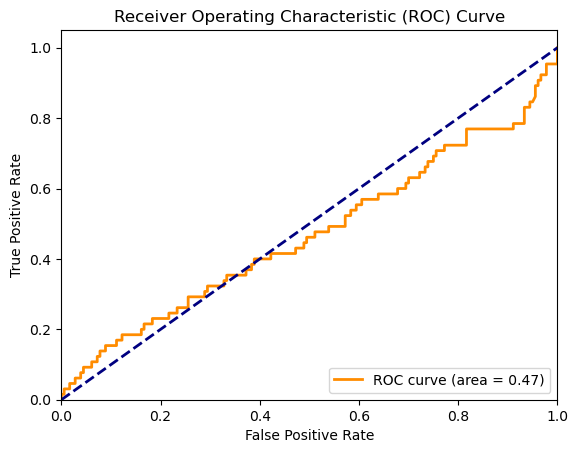

In [201]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

subset = corr_m.loc[corr_m['cls']!='NA']

X = subset.loc[:, big_five].values
y = subset['cls'].values == 'positive'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Random Forest classifier
rf = RandomForestClassifier()

# Define the hyperparameter search space
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=0, n_jobs=-1)

# Perform the grid search by fitting the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best accuracy score
print("Best parameters found:", grid_search.best_params_)
print("Best accuracy score found:", grid_search.best_score_)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

# Calculate the predicted probabilities on the test set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve and AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

       False       0.73      0.73      0.73       180
        True       0.26      0.26      0.26        65

    accuracy                           0.60       245
   macro avg       0.49      0.49      0.49       245
weighted avg       0.61      0.60      0.61       245



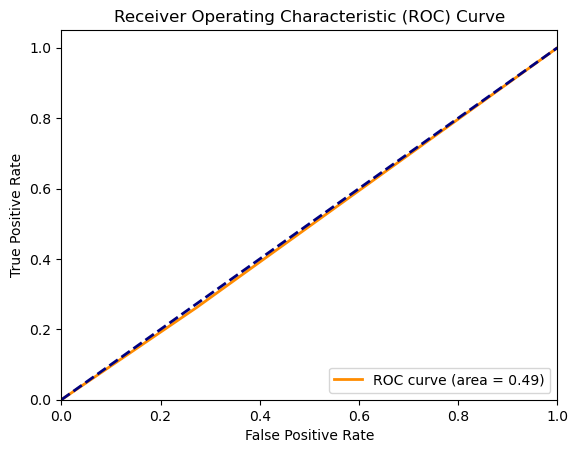

In [202]:
from sklearn.dummy import DummyClassifier

# Create a random classifier that predicts class labels based on the class distribution
random_clf = DummyClassifier(strategy='stratified', random_state=42)
random_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = random_clf.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

# Calculate the predicted probabilities on the test set
y_pred_proba = random_clf.predict_proba(X_test)[:, 1]

# Calculate the ROC curve and AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best accuracy score found: 0.6749802756154007


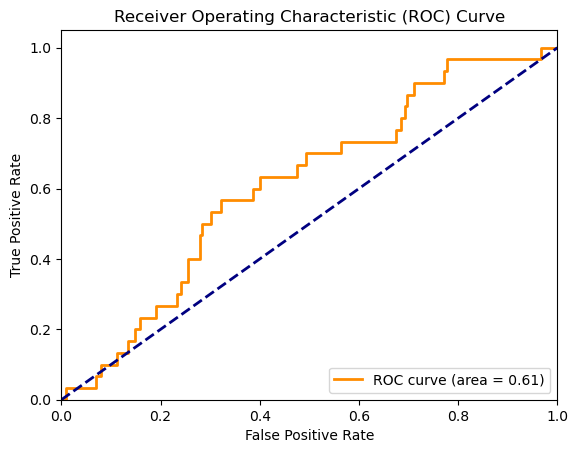

In [225]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

subset = corr_m.loc[corr_m['cls']!='NA']

X = subset.loc[:, big_five].values
y = subset['cls'].values == 'negative'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Random Forest classifier
rf = RandomForestClassifier()

# Define the hyperparameter search space
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=0, n_jobs=-1)

# Perform the grid search by fitting the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best accuracy score
print("Best parameters found:", grid_search.best_params_)
print("Best accuracy score found:", grid_search.best_score_)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Print the classification report
#print(classification_report(y_test, y_pred))


# Calculate the predicted probabilities on the test set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve and AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [227]:
big_five

['NEO_Neuroticism',
 'NEO_Extraversion',
 'NEO_Openness',
 'NEO_Agreeableness',
 'NEO_Conscientiousness']

In [226]:
best_model.feature_importances_

array([0.22528683, 0.24655288, 0.16851675, 0.19893018, 0.16071336])

In [199]:
from sklearn.dummy import DummyClassifier

# Create a random classifier that predicts class labels based on the class distribution
random_clf = DummyClassifier(strategy='stratified', random_state=42)
random_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = random_clf.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.87      0.84      0.86       215
        True       0.08      0.10      0.09        30

    accuracy                           0.75       245
   macro avg       0.48      0.47      0.47       245
weighted avg       0.77      0.75      0.76       245



### More variables (other demographis)

In [203]:
corr_m

,corr,pval,cls,NEO_Neuroticism,NEO_Extraversion,NEO_Openness,NEO_Agreeableness,NEO_Conscientiousness
0,NaN,NaN,NA,0.635417,0.500000,0.843750,0.666667,0.885417
1,0.412068,0.183170,neutral,0.291667,0.479167,0.708333,0.614583,0.645833
2,NaN,NaN,NA,0.864583,0.135417,0.739583,0.458333,0.385417
3,NaN,NaN,NA,0.156250,0.614583,0.562500,0.833333,0.822917
4,-0.507873,0.091853,neutral,0.885417,0.416667,0.791667,0.468750,0.281250
...,...,...,...,...,...,...,...,...
1172,0.738866,0.006048,positive,0.208333,0.541667,0.770833,0.562500,0.729167
1173,0.068892,0.831530,neutral,0.791667,0.427083,0.833333,0.739583,0.593750
1174,-0.123278,0.702684,neutral,0.083333,0.739583,0.802083,0.875000,0.770833
1175,NaN,NaN,NA,0.270833,0.635417,0.520833,0.593750,0.708333


In [212]:
vars = ['Income_v2', 'Age', 'Education', 'Gender', 'Political_Views', 'Race_AA']

other_vars = analysis.get_columns(vars)[:,:,0]

df_other_vars = pd.DataFrame(other_vars, columns=vars)

all_df = pd.concat([df_other_vars, corr_m], axis=1)

In [213]:
all_df

,Income_v2,Age,Education,Gender,Political_Views,Race_AA,corr,pval,cls,NEO_Neuroticism,NEO_Extraversion,NEO_Openness,NEO_Agreeableness,NEO_Conscientiousness
0,0.571429,0.578125,0.500,0.0,0.083333,0.0,NaN,NaN,NA,0.635417,0.500000,0.843750,0.666667,0.885417
1,0.571429,0.718750,0.500,0.0,0.000000,0.0,0.412068,0.183170,neutral,0.291667,0.479167,0.708333,0.614583,0.645833
2,0.000000,0.078125,0.000,1.0,0.500000,0.0,NaN,NaN,NA,0.864583,0.135417,0.739583,0.458333,0.385417
3,0.000000,0.453125,0.125,0.0,0.833333,0.0,NaN,NaN,NA,0.156250,0.614583,0.562500,0.833333,0.822917
4,0.285714,0.468750,0.250,0.0,0.500000,0.0,-0.507873,0.091853,neutral,0.885417,0.416667,0.791667,0.468750,0.281250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,0.428571,0.843750,0.500,0.0,0.833333,0.0,0.738866,0.006048,positive,0.208333,0.541667,0.770833,0.562500,0.729167
1173,0.142857,0.218750,0.750,0.0,0.000000,0.0,0.068892,0.831530,neutral,0.791667,0.427083,0.833333,0.739583,0.593750
1174,1.000000,0.843750,0.625,1.0,0.166667,0.0,-0.123278,0.702684,neutral,0.083333,0.739583,0.802083,0.875000,0.770833
1175,0.857143,0.312500,0.500,1.0,0.666667,0.0,NaN,NaN,NA,0.270833,0.635417,0.520833,0.593750,0.708333


Best parameters found: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 10}
Best accuracy score found: 0.6748139333052808


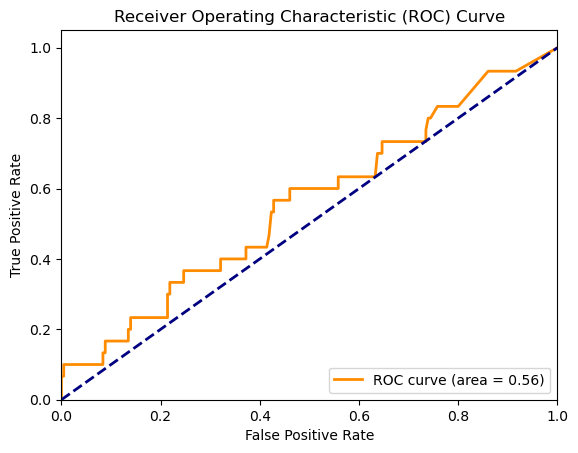

In [217]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

subset = all_df.loc[all_df['cls']!='NA']

X = subset.loc[:, big_five+vars].values
y = subset['cls'].values == 'negative'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Random Forest classifier
rf = RandomForestClassifier()

# Define the hyperparameter search space
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=0, n_jobs=-1)

# Perform the grid search by fitting the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best accuracy score
print("Best parameters found:", grid_search.best_params_)
print("Best accuracy score found:", grid_search.best_score_)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Print the classification report
#print(classification_report(y_test, y_pred))


# Calculate the predicted probabilities on the test set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve and AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [220]:
result_df = pd.DataFrame({'names': big_five+vars, 'importance': best_model.feature_importances_})

In [221]:
result_df

,names,importance
0,NEO_Neuroticism,0.134762
1,NEO_Extraversion,0.197659
2,NEO_Openness,0.120129
3,NEO_Agreeableness,0.154184
4,NEO_Conscientiousness,0.102597
5,Income_v2,0.039203
6,Age,0.097253
7,Education,0.046914
8,Gender,0.007619
9,Political_Views,0.095239


### Selected variables

Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}
Best accuracy score found: 0.6837306701030927


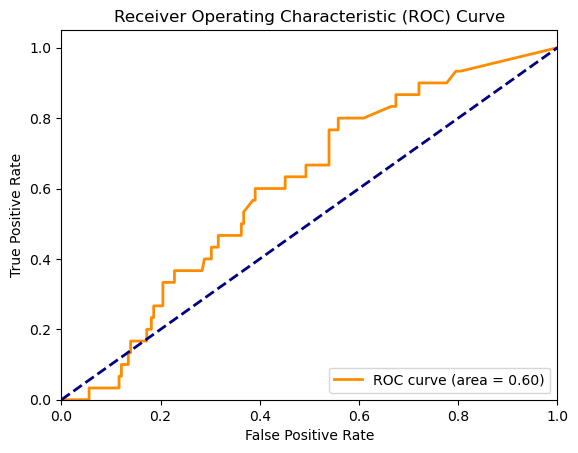

In [222]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

subset = all_df.loc[all_df['cls']!='NA']

selected = big_five + ['Income_v2', 'Political_Views']

X = subset.loc[:, selected].values
y = subset['cls'].values == 'negative'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Random Forest classifier
rf = RandomForestClassifier()

# Define the hyperparameter search space
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=0, n_jobs=-1)

# Perform the grid search by fitting the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best accuracy score
print("Best parameters found:", grid_search.best_params_)
print("Best accuracy score found:", grid_search.best_score_)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Print the classification report
#print(classification_report(y_test, y_pred))


# Calculate the predicted probabilities on the test set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve and AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [224]:
result_df = pd.DataFrame({'names': selected, 'importance': best_model.feature_importances_})
result_df

,names,importance
0,NEO_Neuroticism,0.177519
1,NEO_Extraversion,0.188437
2,NEO_Openness,0.162862
3,NEO_Agreeableness,0.169084
4,NEO_Conscientiousness,0.153624
5,Income_v2,0.055755
6,Political_Views,0.092719


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Best accuracy score found: 0.6347182042920261


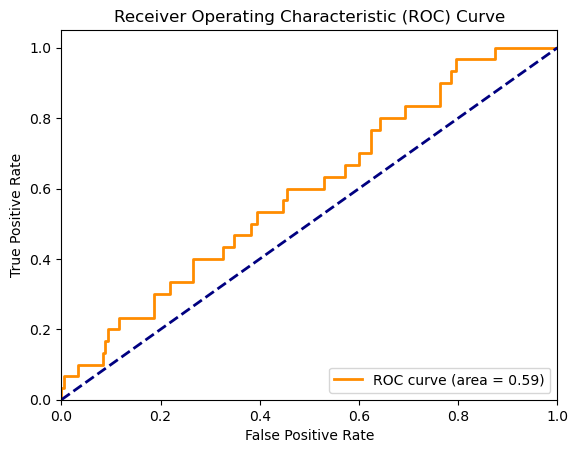

In [229]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

subset = all_df.loc[all_df['cls']!='NA']

selected = ['NEO_Neuroticism', 'NEO_Extraversion', 'Income_v2']

X = subset.loc[:, selected].values
y = subset['cls'].values == 'negative'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Random Forest classifier
rf = RandomForestClassifier()

# Define the hyperparameter search space
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=0, n_jobs=-1)

# Perform the grid search by fitting the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best accuracy score
print("Best parameters found:", grid_search.best_params_)
print("Best accuracy score found:", grid_search.best_score_)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Print the classification report
#print(classification_report(y_test, y_pred))


# Calculate the predicted probabilities on the test set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve and AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Best parameters found: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}
Best accuracy score found: 0.6701440092165899


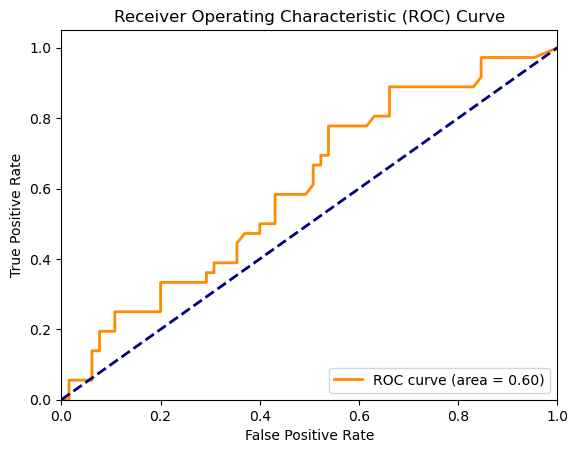

In [231]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

subset = all_df.loc[(all_df['cls']!='NA') & ((all_df['cls'].values == 'negative') | (all_df['cls'].values == 'positive'))]

selected = ['NEO_Neuroticism', 'NEO_Extraversion', 'Income_v2']

X = subset.loc[:, selected].values
y = subset['cls'].values == 'negative'


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Random Forest classifier
rf = RandomForestClassifier()

# Define the hyperparameter search space
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=0, n_jobs=-1)

# Perform the grid search by fitting the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best accuracy score
print("Best parameters found:", grid_search.best_params_)
print("Best accuracy score found:", grid_search.best_score_)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Print the classification report
#print(classification_report(y_test, y_pred))


# Calculate the predicted probabilities on the test set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve and AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Check changes in SAH

## Visualization of changes in SAH

In [1323]:
SAH = analysis.data[:, analysis.index_sah, :]

In [1324]:
dif = np.diff(SAH, axis=1)
n_ones = np.sum(dif == 1, axis=1)

np.sum(n_ones == 1)


24

In [1325]:
np.sum(dif == 1)

24

In [1326]:
len(n_ones)

1177

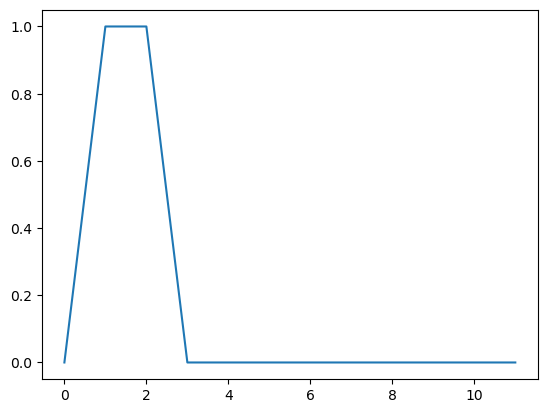

In [1327]:
plt.plot(SAH[n_ones==1, :][0])

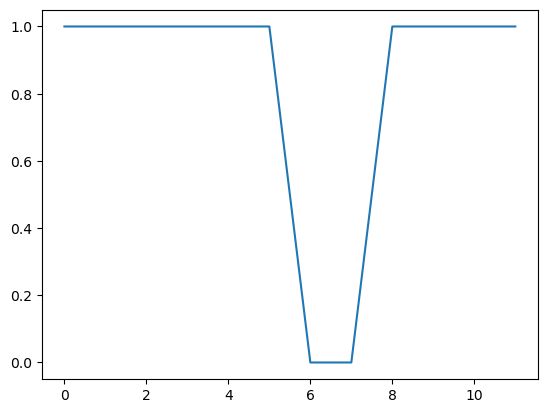

In [1331]:
plt.plot(SAH[n_ones==1, :][4])

# Checking the NEO_FFI and its correlation with BDI

## Statistics of individual changes of personality across waves

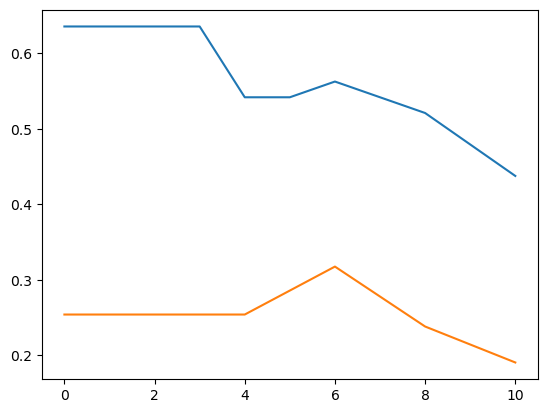

In [1332]:
plt.plot(data.loc[data['ids']==2,'NEO_Neuroticism'].values)
plt.plot(data.loc[data['ids']==2,'BDI'].values)


In [1333]:
result = analysis.test_correlation('NEO_Neuroticism')
print(result['significance'].sum())
print((result['significance'] & result['positive']).sum())

382
291


/home/andy/anaconda3/envs/g/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [1334]:
result = analysis.test_correlation('NEO_Extraversion')
print(result['significance'].sum())
print((result['significance'] & result['positive']).sum())

380
144


/home/andy/anaconda3/envs/g/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [1335]:
result = analysis.test_correlation('NEO_Conscientiousness')
print(result['significance'].sum())
print((result['significance'] & result['positive']).sum())

382
155


/home/andy/anaconda3/envs/g/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [1336]:
result = analysis.test_correlation('NEO_Openness')
print(result['significance'].sum())
print((result['significance'] & result['positive']).sum())

346
169


/home/andy/anaconda3/envs/g/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [1337]:
result = analysis.test_correlation('NEO_Agreeableness')
print(result['significance'].sum())
print((result['significance'] & result['positive']).sum())

363
153


/home/andy/anaconda3/envs/g/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [1338]:
result['significance'].sum()

363

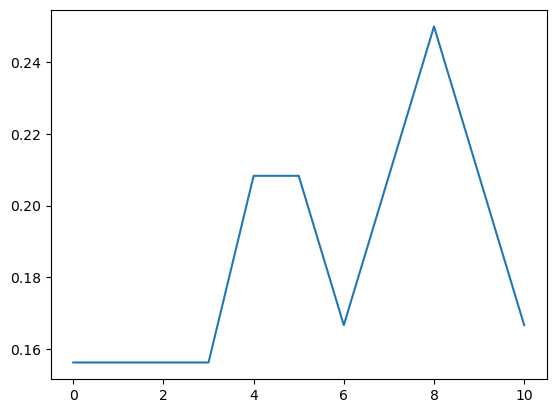

In [1339]:
plt.plot(data.loc[3,'NEO_Neuroticism'].values)

In [1343]:
big_five

['NEO_Neuroticism',
 'NEO_Extraversion',
 'NEO_Openness',
 'NEO_Agreeableness',
 'NEO_Conscientiousness']

In [1341]:
data['week'] = data['wave'].replace(wave_weeks)

In [1347]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

corrs = []

ids = np.unique(data.loc[:, 'ids'].values)

for var in big_five:
    var_corrs = np.empty(len(ids))
    var_pvals = np.empty(len(ids))
    for i in range(len(ids)):
        var_vals = data.loc[data['ids']==ids[i], var].values
        week_vals = data.loc[data['ids']==ids[i], 'week'].values

        if len(np.unique(var_vals)!=1):
            # Correlation analysis
            corr = stats.pearsonr(var_vals, week_vals)
            var_corrs[i] = corr[0]
            var_pvals[i] = corr[1]
        
    var_corrs = var_corrs[~np.isnan(var_corrs)]
    var_pvals = var_pvals[~np.isnan(var_pvals)]

    significant = var_pvals < 0.05

    corr_count = var_corrs > 0
    print('===' + var)
    n_positive = np.sum(corr_count)
    n_negative = np.sum(var_corrs < 0)

    n_pos_significant = np.sum(significant & (var_corrs > 0))
    n_neg_significant = np.sum(significant & (var_corrs < 0))


    n_zero = np.sum(var_corrs == 0)
    n = len(corr_count)

    pos_percentage = np.round(n_positive/n, 2)
    neg_percentage = np.round(n_negative/n, 2)
    print('Total number of subjects: ' + str(n))
    print('N positive: ' + str(n_positive) + '({})'.format(str(pos_percentage)))

    print('N negative: ' + str(n_negative) + '({})'.format((str(neg_percentage))) )
    print('N zero: ' + str(n_zero))
    print('pval: ' + str(stats.binom_test(n_positive, n)))

    print('N positive significant: ' + str(n_pos_significant))
    print('N negative significant: ' + str(n_neg_significant))


/home/andy/anaconda3/envs/g/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


===NEO_Neuroticism
Total number of subjects: 1145
N positive: 549(0.48)
N negative: 596(0.52)
N zero: 0
pval: 0.1739855629006471
N positive significant: 286
N negative significant: 328
===NEO_Extraversion
Total number of subjects: 1147
N positive: 578(0.5)
N negative: 569(0.5)
N zero: 0
pval: 0.8132780906345569
N positive significant: 285
N negative significant: 295
===NEO_Openness
Total number of subjects: 1139
N positive: 568(0.5)
N negative: 571(0.5)
N zero: 0
pval: 0.9527477610507908
N positive significant: 319
N negative significant: 271
===NEO_Agreeableness
Total number of subjects: 1143
N positive: 600(0.52)
N negative: 543(0.48)
N zero: 0
pval: 0.09759845947988958
N positive significant: 326
N negative significant: 296
===NEO_Conscientiousness
Total number of subjects: 1131
N positive: 541(0.48)
N negative: 590(0.52)
N zero: 0
pval: 0.15346707641243126
N positive significant: 266
N negative significant: 310


## Histogram of effect size comparing wave2 and wave 13

/home/andy/anaconda3/envs/g/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


NEO_Neuroticism


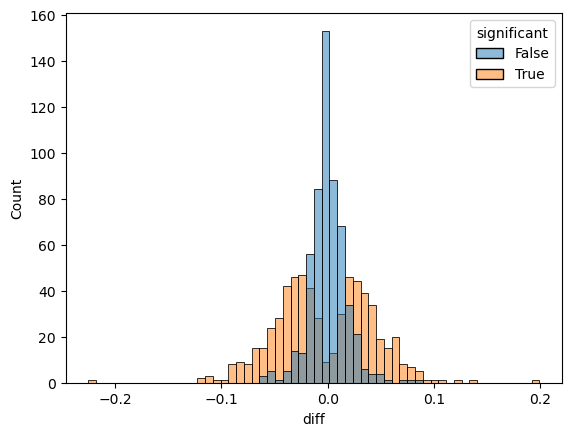

/home/andy/anaconda3/envs/g/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


NEO_Extraversion


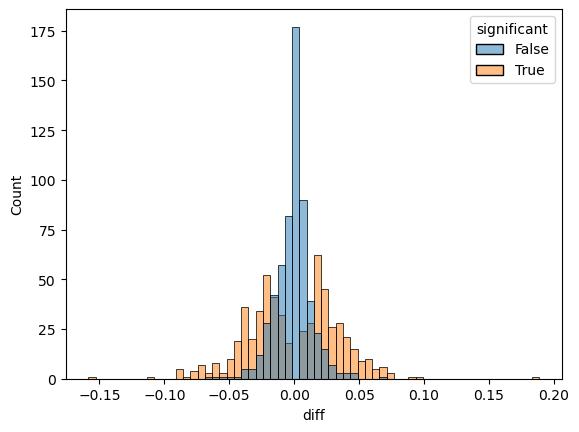

/home/andy/anaconda3/envs/g/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


NEO_Openness


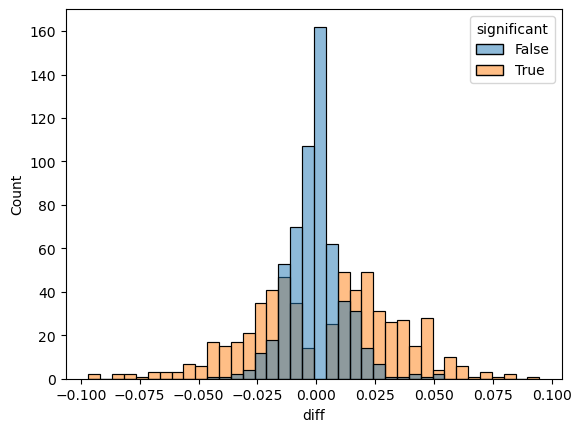

/home/andy/anaconda3/envs/g/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


NEO_Agreeableness


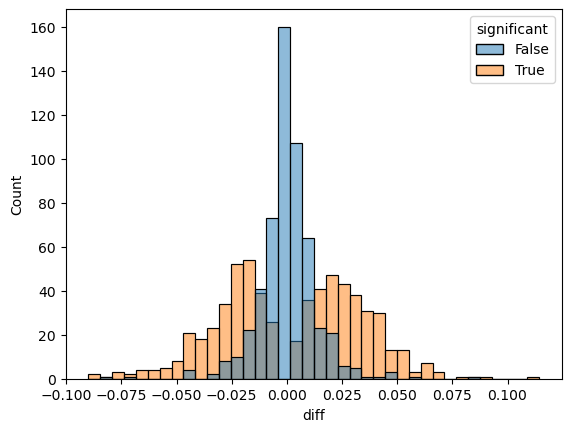

/home/andy/anaconda3/envs/g/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


NEO_Conscientiousness


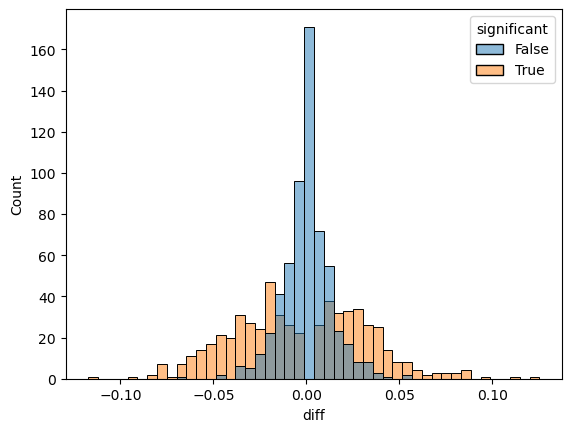

In [1356]:
subset = data.loc[:, ['wave', 'week', 'NEO_Neuroticism', 'NEO_Extraversion', 'NEO_Openness', 'NEO_Agreeableness', 'NEO_Conscientiousness']]

for var in big_five:
    predict_week2 = []
    predict_week12 = []
    var_corrs = np.empty(len(ids))
    var_pvals = np.empty(len(ids))
    for i in range(len(ids)):
        var_vals = subset.loc[data['ids']==ids[i], var].values
        week_vals = subset.loc[data['ids']==ids[i], 'week'].values

        if len(np.unique(var_vals)!=1):
        # Correlation analysis
            corr = stats.pearsonr(var_vals, week_vals)
            var_corrs[i] = corr[0]
            var_pvals[i] = corr[1]

            # Regression Analysis
            week_vals_c = sm.add_constant(week_vals.T)
            
            results = sm.OLS(var_vals, week_vals_c).fit()

            predict_week2.append(results.predict([[1,2]])[0])
            predict_week12.append(results.predict([[1,12]])[0])

    pred_diff = np.array(predict_week12) - np.array(predict_week2)

    significant = var_pvals < 0.05
    print(var)

    df = pd.DataFrame({'significant': significant, 
                                 'diff': pred_diff})
    sns.histplot(df, x='diff', hue='significant')
    plt.show()


In [1348]:
waves = np.unique(data['wave'].values)
groupby_big_five = data.groupby('wave').mean(big_five)


In [1349]:
weeks = np.unique(data['week'])
weeks

array([ 2,  3,  4,  6,  8, 10, 13, 16, 19, 22, 25])

In [1350]:
print(weeks)
print(stats.pearsonr(groupby_big_five['NEO_Neuroticism'].values, weeks))
print(stats.pearsonr(groupby_big_five['NEO_Extraversion'].values, weeks))
print(stats.pearsonr(groupby_big_five['NEO_Agreeableness'].values, weeks))
print(stats.pearsonr(groupby_big_five['NEO_Openness'].values, weeks))
print(stats.pearsonr(groupby_big_five['NEO_Conscientiousness'].values, weeks))

[ 2  3  4  6  8 10 13 16 19 22 25]
PearsonRResult(statistic=-0.7787765542283728, pvalue=0.004738192683934368)
PearsonRResult(statistic=-0.6654526270333457, pvalue=0.025434011617669547)
PearsonRResult(statistic=0.6773918179604068, pvalue=0.02202102765078896)
PearsonRResult(statistic=0.8823379269772527, pvalue=0.0003239367944555742)
PearsonRResult(statistic=-0.6919776107036623, pvalue=0.018309540446218374)


In [1351]:
big_five

['NEO_Neuroticism',
 'NEO_Extraversion',
 'NEO_Openness',
 'NEO_Agreeableness',
 'NEO_Conscientiousness']

In [1354]:
melted = pd.melt(subset, id_vars=['week'], value_vars=['NEO_Neuroticism', 'NEO_Extraversion', 'NEO_Openness', 'NEO_Agreeableness', 'NEO_Conscientiousness'])

<AxesSubplot:xlabel='week', ylabel='value'>

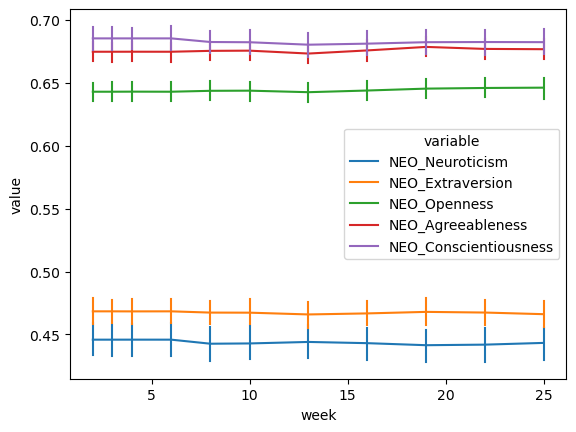

In [1355]:
sns.lineplot(data=melted, x='week', y='value', hue='variable', ci=95, err_style='bars')

# Association between BDI and covid severity for people who are all under lockdown or not.

In [1358]:
SAH1_indexes = []
SAH0_indexes = []
for i in range(analysis.data.shape[0]):
    if (analysis.data[i, analysis.index_sah, :] == 1).all():
        SAH1_indexes.append(i)
    elif (analysis.data[i, analysis.index_sah, :] == 0).all():
        SAH0_indexes.append(i)

print(len(SAH1_indexes))
print(len(SAH0_indexes))


273
45


In [1359]:
SAH1 = analysis.data[SAH1_indexes, :, :]
SAH0 = analysis.data[SAH0_indexes, :, :]

SAH1_bdi = SAH1[:, analysis.index_bdi, :]
SAH0_bdi = SAH0[:, analysis.index_bdi, :]

In [1360]:
1177-(272+45)

860

## Number of people with positive vs negative correlation of covid severity and BDI：among people who are under lockdown

In [1362]:
covid_related_variables = ['cases_avg',
                        'deaths_avg',
                        'cases_avg_per_100k',
                        'deaths_avg_per_100k']

# X = analysis.get_columns(covid_related_variables)

# X_SAH1 = X[SAH1_indexes, :, :]
# X_SAH0 = X[SAH0_indexes, :, :]

# pca_transformed = np.zeros((X_SAH1.shape[0], X_SAH1.shape[2]))

# for i in range(X_SAH1.shape[2]):
#     pca = PCA(n_components=1, svd_solver='full')
#     pca.fit(X_SAH1[:,:,i])
#     pca_covid_severity = np.squeeze(pca.transform(X_SAH1[:,:,i]))
#     pca_transformed[:,i] = pca_covid_severity

cvd_cases = analysis.data[SAH1_indexes, analysis.columns.index('cases_avg_per_100k'), :]

corr_out = []
pval_out = []

print(cvd_cases.shape)

for i in range(cvd_cases.shape[0]):
    pearson_corr = stats.pearsonr(cvd_cases[i,:], SAH1_bdi[i,:])
    corr_out.append(pearson_corr[0])
    pval_out.append(pearson_corr[1])

df = pd.DataFrame({'corr':corr_out, 'pval':pval_out})
significant_positive_corr = (df['pval'] < 0.05) & (df['corr'] > 0).values
significant_negative_corr = (df['pval'] < 0.05) & (df['corr'] < 0).values
print(np.sum(significant_positive_corr))
print(np.sum(significant_negative_corr))

(273, 12)
39
62


/home/andy/anaconda3/envs/g/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


## Number of people with positive vs negative correlation of covid severity and BDI：among people who are not under lockdown

In [1368]:
covid_related_variables = ['cases_avg',
                        'deaths_avg',
                        'cases_avg_per_100k',
                        'deaths_avg_per_100k']

# X = analysis.get_columns(covid_related_variables)

# X_SAH1 = X[SAH1_indexes, :, :]
# X_SAH0 = X[SAH0_indexes, :, :]

# pca_transformed = np.zeros((X_SAH1.shape[0], X_SAH1.shape[2]))

# for i in range(X_SAH1.shape[2]):
#     pca = PCA(n_components=1, svd_solver='full')
#     pca.fit(X_SAH1[:,:,i])
#     pca_covid_severity = np.squeeze(pca.transform(X_SAH1[:,:,i]))
#     pca_transformed[:,i] = pca_covid_severity

cvd_cases = analysis.data[SAH0_indexes, analysis.columns.index('cases_avg_per_100k'), :]

corr_out = []
pval_out = []

print(cvd_cases.shape)

for i in range(cvd_cases.shape[0]):
    pearson_corr = stats.pearsonr(cvd_cases[i,:], SAH1_bdi[i,:])
    corr_out.append(pearson_corr[0])
    pval_out.append(pearson_corr[1])

df = pd.DataFrame({'corr':corr_out, 'pval':pval_out})
significant_positive_corr = (df['pval'] < 0.05) & (df['corr'] > 0).values
significant_negative_corr = (df['pval'] < 0.05) & (df['corr'] < 0).values
print(np.sum(significant_positive_corr))
print(np.sum(significant_negative_corr))

(45, 12)
8
11


/home/andy/anaconda3/envs/g/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


## GLMM with subjects under lockdown

In [1366]:
SAH1_cvdids = analysis.ids[SAH1_indexes]
SAH1_data = selected_data.loc[selected_data['ids'].isin(SAH1_cvdids),:]

In [1367]:
model = Lmer("BDI ~ week + Fear + NEO_Extraversion + NEO_Neuroticism + NEO_Conscientiousness + NEO_Agreeableness + NEO_Openness + Education + Income_v2 + Gender + Political_Views + Age + Race_W + Race_AA + Race_A + deaths_avg_per_100k + cases_avg_per_100k + (1 + week |ids)", data=SAH1_data)
model.fit()
model.summary()

/home/andy/anaconda3/envs/g/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


Linear mixed model fit by REML [’lmerMod’]
Formula: BDI~week+Fear+NEO_Extraversion+NEO_Neuroticism+NEO_Conscientiousness+NEO_Agreeableness+NEO_Openness+Education+Income_v2+Gender+Political_Views+Age+Race_W+Race_AA+Race_A+deaths_avg_per_100k+cases_avg_per_100k+(1+week|ids)

Family: gaussian	 Inference: parametric

Number of observations: 2948	 Groups: {'ids': 268.0}

Log-likelihood: 4446.345 	 AIC: -8848.691

Random effects:

                 Name    Var    Std
ids       (Intercept)  0.020  0.140
ids              week  0.000  0.004
Residual               0.001  0.039

             IV1   IV2   Corr
ids  (Intercept)  week -0.398

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: BDI~week+Fear+NEO_Extraversion+NEO_Neuroticism+NEO_Conscientiousness+NEO_Agreeableness+NEO_Openness+Education+Income_v2+Gender+Political_Views+Age+Race_W+Race_AA+Race_A+deaths_avg_per_100k+cases_avg_per_100k+(1+week|ids)

Family: gaussian	 Inference: parametric

Number of observations: 2948	 Grou

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.201,0.110,0.292,0.046,901.636,4.318,0.000,***
week,-0.001,-0.001,-0.000,0.000,317.604,-3.320,0.001,**
Fear,0.023,0.005,0.041,0.009,2771.697,2.499,0.013,*
NEO_Extraversion,-0.070,-0.120,-0.021,0.025,2597.225,-2.785,0.005,**
NEO_Neuroticism,0.268,0.226,0.310,0.022,2657.441,12.430,0.000,***
NEO_Conscientiousness,-0.024,-0.079,0.031,0.028,2486.363,-0.853,0.394,
NEO_Agreeableness,-0.130,-0.187,-0.073,0.029,2698.465,-4.464,0.000,***
NEO_Openness,0.082,0.025,0.138,0.029,2604.449,2.823,0.005,**
Education,-0.054,-0.134,0.027,0.041,237.970,-1.308,0.192,
Income_v2,-0.002,-0.014,0.009,0.006,2749.346,-0.378,0.705,


## GLMM with subjects not under lockdown

In [1370]:
SAH0_cvdids = analysis.ids[SAH0_indexes]
SAH0_data = selected_data.loc[selected_data['ids'].isin(SAH0_cvdids),:]

In [1371]:
model = Lmer("BDI ~ week + Fear + NEO_Extraversion + NEO_Neuroticism + NEO_Conscientiousness + NEO_Agreeableness + NEO_Openness + Education + Income_v2 + Gender + Political_Views + Age + Race_W + Race_AA + Race_A + deaths_avg_per_100k + cases_avg_per_100k + (1 + week |ids)", data=SAH0_data)
model.fit()
model.summary()

/home/andy/anaconda3/envs/g/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


Linear mixed model fit by REML [’lmerMod’]
Formula: BDI~week+Fear+NEO_Extraversion+NEO_Neuroticism+NEO_Conscientiousness+NEO_Agreeableness+NEO_Openness+Education+Income_v2+Gender+Political_Views+Age+Race_W+Race_AA+Race_A+deaths_avg_per_100k+cases_avg_per_100k+(1+week|ids)

Family: gaussian	 Inference: parametric

Number of observations: 495	 Groups: {'ids': 45.0}

Log-likelihood: 810.952 	 AIC: -1579.903

Random effects:

                 Name    Var    Std
ids       (Intercept)  0.014  0.117
ids              week  0.000  0.004
Residual               0.001  0.032

             IV1   IV2   Corr
ids  (Intercept)  week -0.062

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: BDI~week+Fear+NEO_Extraversion+NEO_Neuroticism+NEO_Conscientiousness+NEO_Agreeableness+NEO_Openness+Education+Income_v2+Gender+Political_Views+Age+Race_W+Race_AA+Race_A+deaths_avg_per_100k+cases_avg_per_100k+(1+week|ids)

Family: gaussian	 Inference: parametric

Number of observations: 495	 Groups: 

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.386,0.147,0.624,0.122,80.791,3.166,0.002,**
week,0.000,-0.001,0.002,0.001,49.953,0.669,0.506,
Fear,0.019,-0.022,0.060,0.021,448.706,0.914,0.361,
NEO_Extraversion,-0.104,-0.225,0.017,0.062,306.644,-1.691,0.092,.
NEO_Neuroticism,0.322,0.211,0.432,0.056,263.251,5.695,0.000,***
NEO_Conscientiousness,0.009,-0.129,0.146,0.070,407.459,0.122,0.903,
NEO_Agreeableness,-0.166,-0.306,-0.026,0.071,425.751,-2.329,0.020,*
NEO_Openness,-0.199,-0.339,-0.060,0.071,298.458,-2.804,0.005,**
Education,-0.010,-0.205,0.185,0.099,34.747,-0.099,0.922,
Income_v2,-0.003,-0.034,0.028,0.016,449.367,-0.184,0.854,


## GLMM on Combining both under vs not under lockdown 

This could be some kind of an evidence that the effect of lockdowns affect people individually and longitudinally (and an interaction between the two), but not cross-sectionally. But also I would assume that people who are under lockdown always have higher casea than people who are always not under lockdown, but the regression model tells that the death/cases are not predictive of BDI, it kind of shows that the absolute death/cases and SAH have little effect on people's BDI, it's the dynamic of policy changes and covid cases/death that causes the changes of individual BDI. I am guessing that because of the change of policy and environment that increases the uncertainty that people experiences. And one of this factor can be revealed by the fear score. 

In [1375]:
SAH10_cvdids = analysis.ids[np.hstack([SAH1_indexes,SAH0_indexes])]
SAH10_data = selected_data.loc[selected_data['ids'].isin(SAH10_cvdids),:]

In [1380]:
model = Lmer("BDI ~ Mandatory_SAH*week + Fear + NEO_Extraversion + NEO_Neuroticism + NEO_Conscientiousness + NEO_Agreeableness + NEO_Openness + Education + Income_v2 + Gender + Political_Views + Age + Race_W + Race_AA + Race_A + deaths_avg_per_100k + cases_avg_per_100k + (1 + week |ids)", data=SAH10_data)
model.fit()
model.summary()

/home/andy/anaconda3/envs/g/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


Model failed to converge with max|grad| = 0.00934801 (tol = 0.002, component 1) 

Linear mixed model fit by REML [’lmerMod’]
Formula: BDI~Mandatory_SAH*week+Fear+NEO_Extraversion+NEO_Neuroticism+NEO_Conscientiousness+NEO_Agreeableness+NEO_Openness+Education+Income_v2+Gender+Political_Views+Age+Race_W+Race_AA+Race_A+deaths_avg_per_100k+cases_avg_per_100k+(1+week|ids)

Family: gaussian	 Inference: parametric

Number of observations: 3443	 Groups: {'ids': 313.0}

Log-likelihood: 5261.465 	 AIC: -10474.931

Random effects:

                 Name    Var    Std
ids       (Intercept)  0.019  0.136
ids              week  0.000  0.004
Residual               0.001  0.038

             IV1   IV2   Corr
ids  (Intercept)  week -0.353

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: BDI~Mandatory_SAH*week+Fear+NEO_Extraversion+NEO_Neuroticism+NEO_Conscientiousness+NEO_Agreeableness+NEO_Openness+Education+Income_v2+Gender+Political_Views+Age+Race_W+Race_AA+Race_A+deaths_avg_per_10

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.205,0.114,0.296,0.047,775.292,4.399,0.000,***
Mandatory_SAH,0.019,-0.025,0.064,0.023,290.417,0.846,0.398,
week,0.000,-0.001,0.001,0.001,324.206,0.337,0.737,
Fear,0.023,0.006,0.040,0.008,3231.837,2.720,0.007,**
NEO_Extraversion,-0.075,-0.121,-0.029,0.023,2964.534,-3.218,0.001,**
NEO_Neuroticism,0.272,0.233,0.312,0.020,3029.444,13.591,0.000,***
NEO_Conscientiousness,-0.022,-0.073,0.029,0.026,2925.839,-0.854,0.393,
NEO_Agreeableness,-0.133,-0.186,-0.080,0.027,3164.425,-4.928,0.000,***
NEO_Openness,0.053,0.001,0.105,0.027,2953.003,1.986,0.047,*
Education,-0.053,-0.127,0.021,0.038,277.714,-1.411,0.160,


## GLMM on fear

In [1381]:
model = Lmer("Fear ~ Mandatory_SAH*week + NEO_Extraversion + NEO_Neuroticism + NEO_Conscientiousness + NEO_Agreeableness + NEO_Openness + Education + Income_v2 + Gender + Political_Views + Age + Race_W + Race_AA + Race_A + deaths_avg_per_100k + cases_avg_per_100k + (1 + week |ids)", data=SAH10_data)
model.fit()
model.summary()

/home/andy/anaconda3/envs/g/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


Linear mixed model fit by REML [’lmerMod’]
Formula: Fear~Mandatory_SAH*week+NEO_Extraversion+NEO_Neuroticism+NEO_Conscientiousness+NEO_Agreeableness+NEO_Openness+Education+Income_v2+Gender+Political_Views+Age+Race_W+Race_AA+Race_A+deaths_avg_per_100k+cases_avg_per_100k+(1+week|ids)

Family: gaussian	 Inference: parametric

Number of observations: 3443	 Groups: {'ids': 313.0}

Log-likelihood: 2934.323 	 AIC: -5822.647

Random effects:

                 Name    Var    Std
ids       (Intercept)  0.036  0.189
ids              week  0.000  0.005
Residual               0.006  0.080

             IV1   IV2   Corr
ids  (Intercept)  week -0.094

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: Fear~Mandatory_SAH*week+NEO_Extraversion+NEO_Neuroticism+NEO_Conscientiousness+NEO_Agreeableness+NEO_Openness+Education+Income_v2+Gender+Political_Views+Age+Race_W+Race_AA+Race_A+deaths_avg_per_100k+cases_avg_per_100k+(1+week|ids)

Family: gaussian	 Inference: parametric

Number of obse

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.479,0.328,0.631,0.077,835.933,6.196,0.000,***
Mandatory_SAH,-0.012,-0.076,0.051,0.032,294.077,-0.374,0.709,
week,-0.003,-0.005,-0.001,0.001,340.108,-3.313,0.001,**
NEO_Extraversion,-0.002,-0.087,0.083,0.043,2083.332,-0.043,0.965,
NEO_Neuroticism,0.099,0.026,0.173,0.038,2181.145,2.646,0.008,**
NEO_Conscientiousness,0.065,-0.030,0.160,0.048,2086.147,1.345,0.179,
NEO_Agreeableness,-0.048,-0.147,0.051,0.051,2346.668,-0.953,0.341,
NEO_Openness,0.015,-0.083,0.112,0.050,2135.737,0.293,0.770,
Education,-0.078,-0.188,0.033,0.056,300.898,-1.376,0.170,
Income_v2,0.005,-0.017,0.026,0.011,3275.163,0.409,0.683,


In [1383]:
model = Lmer("Fear ~ Mandatory_SAH*week + NEO_Extraversion + NEO_Neuroticism + NEO_Conscientiousness + NEO_Agreeableness + NEO_Openness + Education + Income_v2 + Gender + Political_Views + Age + Race_W + Race_AA + Race_A + deaths_avg_per_100k + cases_avg_per_100k + (1 + week |ids)", data=selected_data)
model.fit()
model.summary()

/home/andy/anaconda3/envs/g/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


Model failed to converge with max|grad| = 0.0355914 (tol = 0.002, component 1) 

Linear mixed model fit by REML [’lmerMod’]
Formula: Fear~Mandatory_SAH*week+NEO_Extraversion+NEO_Neuroticism+NEO_Conscientiousness+NEO_Agreeableness+NEO_Openness+Education+Income_v2+Gender+Political_Views+Age+Race_W+Race_AA+Race_A+deaths_avg_per_100k+cases_avg_per_100k+(1+week|ids)

Family: gaussian	 Inference: parametric

Number of observations: 12727	 Groups: {'ids': 1157.0}

Log-likelihood: 11537.923 	 AIC: -23029.847

Random effects:

                 Name    Var    Std
ids       (Intercept)  0.040  0.199
ids              week  0.000  0.004
Residual               0.006  0.076

             IV1   IV2  Corr
ids  (Intercept)  week -0.16

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: Fear~Mandatory_SAH*week+NEO_Extraversion+NEO_Neuroticism+NEO_Conscientiousness+NEO_Agreeableness+NEO_Openness+Education+Income_v2+Gender+Political_Views+Age+Race_W+Race_AA+Race_A+deaths_avg_per_100k+cases

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.364,0.285,0.443,0.040,3549.025,9.003,0.000,***
Mandatory_SAH,0.033,0.026,0.039,0.003,11451.434,9.546,0.000,***
week,-0.001,-0.001,-0.001,0.000,2808.901,-4.737,0.000,***
NEO_Extraversion,0.061,0.016,0.105,0.023,7834.955,2.669,0.008,**
NEO_Neuroticism,0.105,0.067,0.142,0.019,8694.462,5.470,0.000,***
NEO_Conscientiousness,0.091,0.044,0.137,0.024,8901.341,3.813,0.000,***
NEO_Agreeableness,-0.006,-0.057,0.044,0.026,9436.439,-0.245,0.806,
NEO_Openness,0.004,-0.046,0.054,0.026,8192.665,0.143,0.886,
Education,-0.046,-0.101,0.008,0.028,1164.963,-1.670,0.095,.
Income_v2,-0.006,-0.017,0.006,0.006,12269.884,-0.960,0.337,


In [589]:
SAH1_bdi.shape

(272, 16)

In [590]:
mean_cases = np.mean(X_SAH1[:, -1, :], 0)
mean_bdi = np.mean(SAH1_bdi, 0)

In [591]:
stats.pearsonr(mean_cases, mean_bdi)

PearsonRResult(statistic=-0.4784400321203985, pvalue=0.06083617021283051)

In [592]:
mean_bdi_all = np.mean(analysis.data[:, analysis.index_bdi, :], 0)

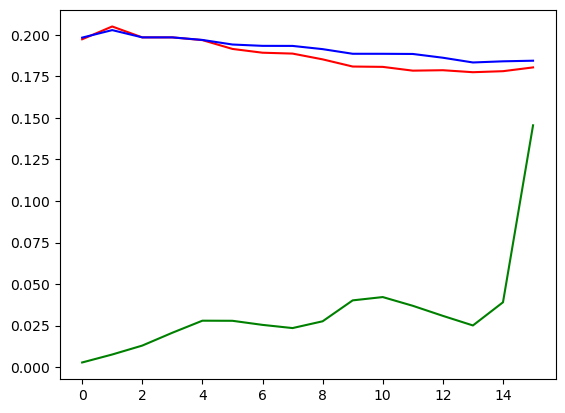

In [593]:
plt.figure()
plt.plot(mean_cases, c='g')
plt.plot(mean_bdi, c='r')
plt.plot(mean_bdi_all, c='b')

/tmp/ipykernel_1349/3318522843.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


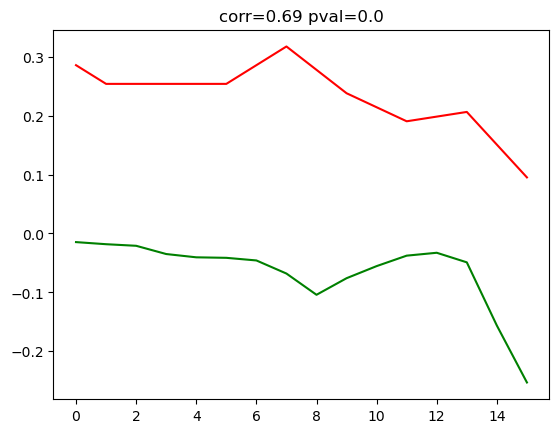

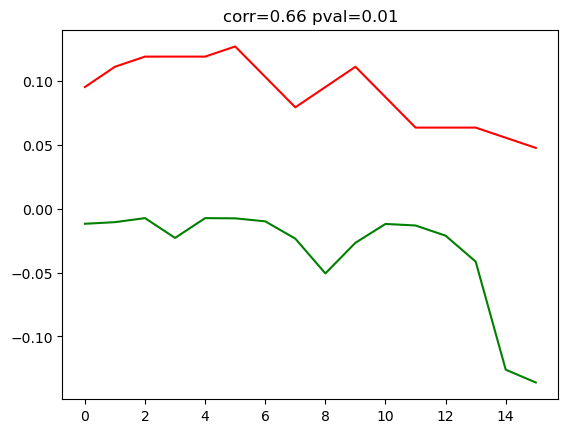

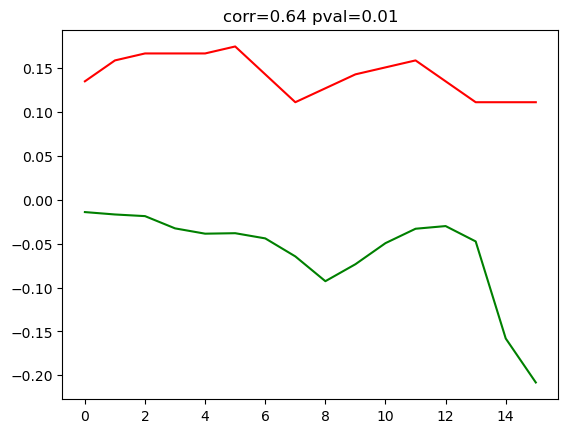

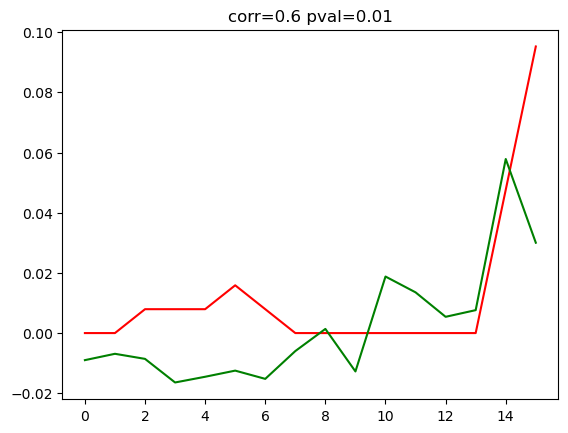

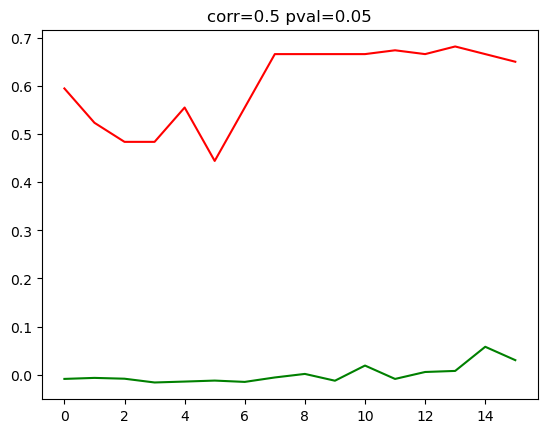

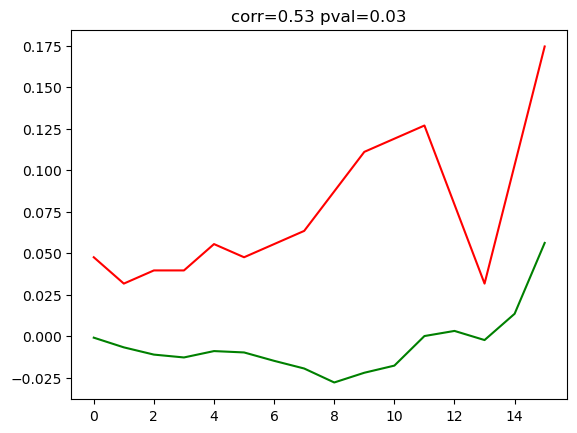

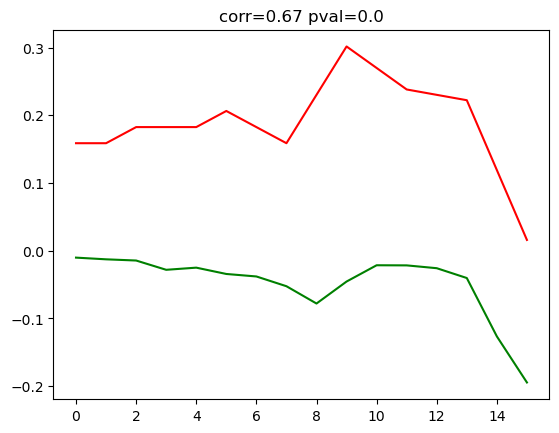

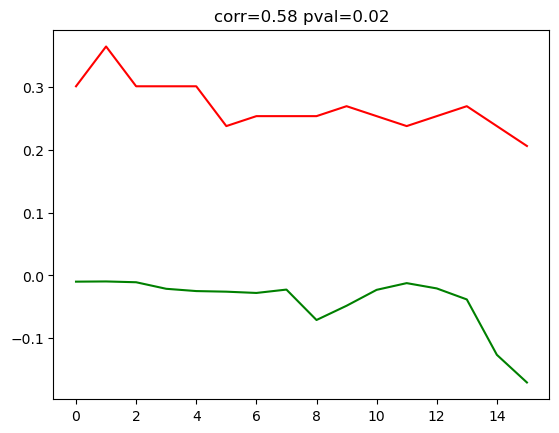

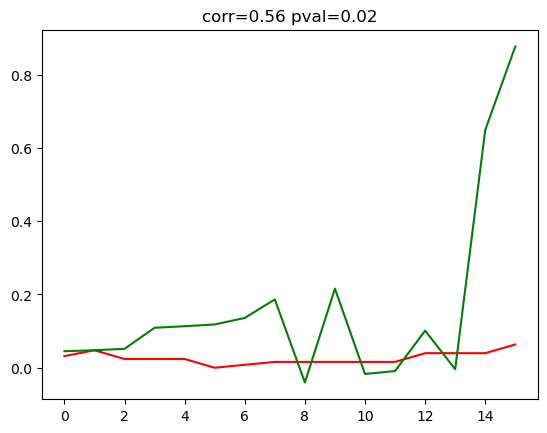

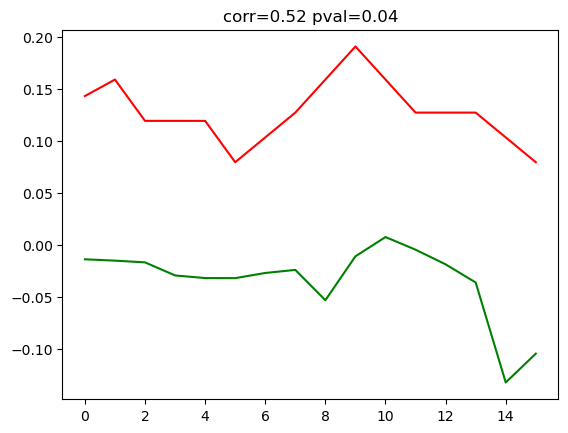

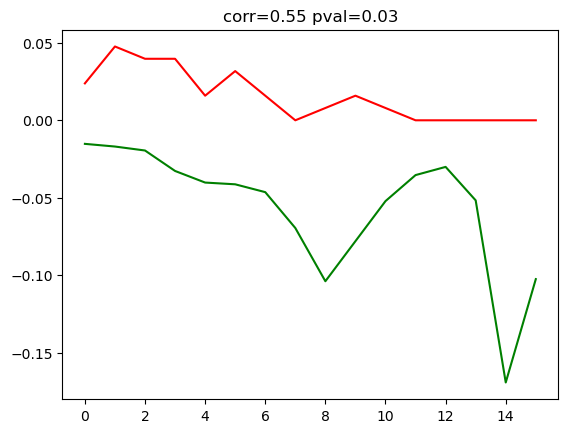

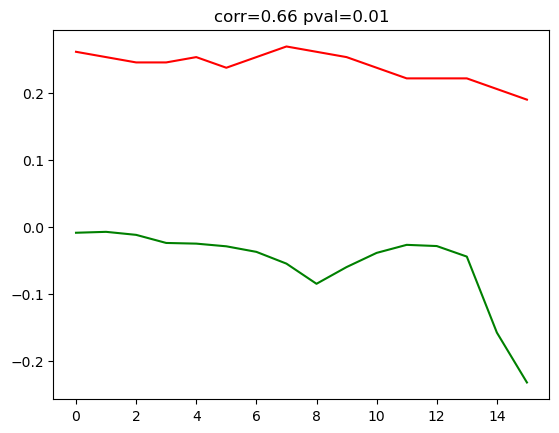

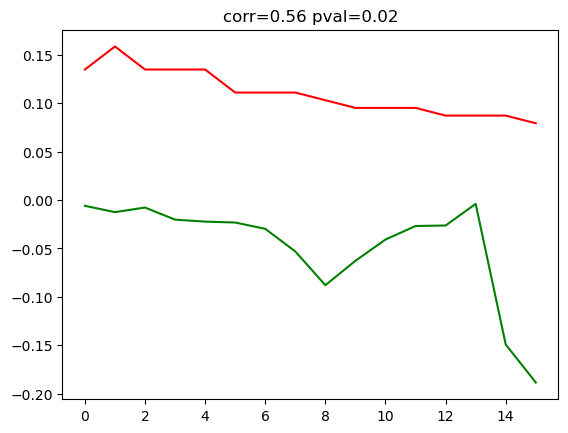

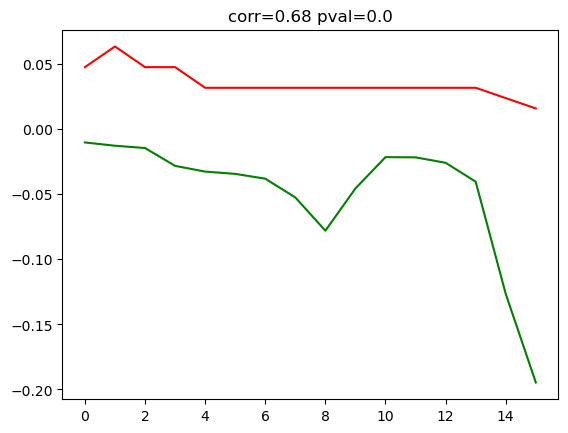

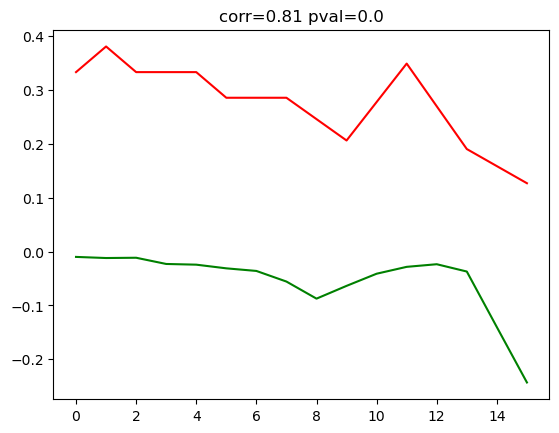

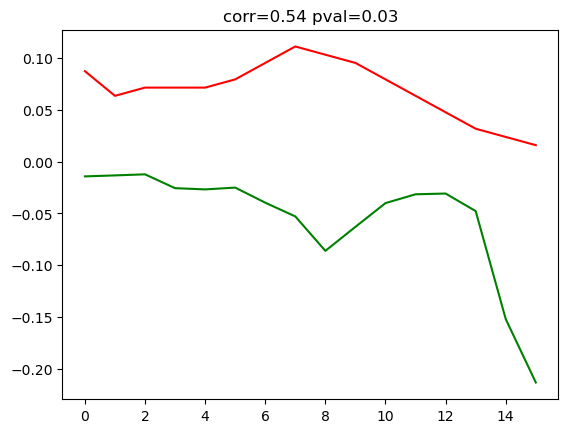

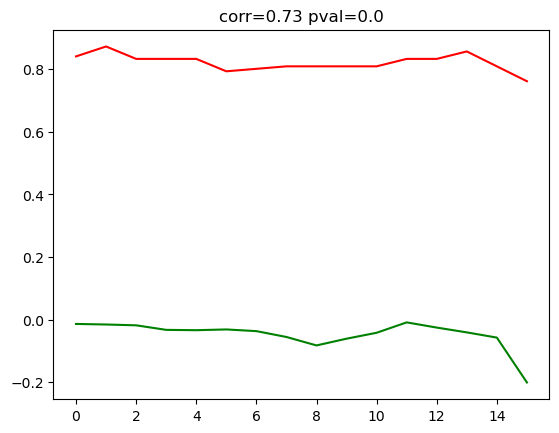

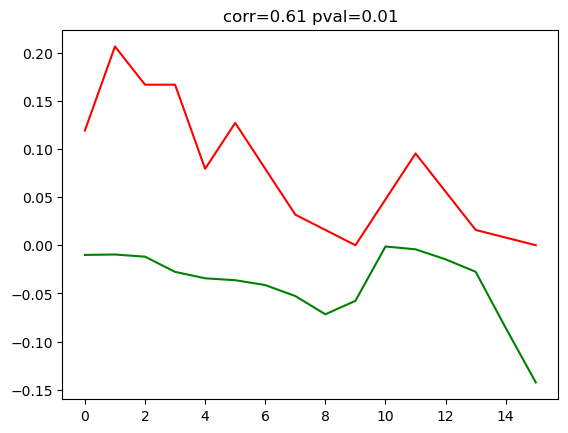

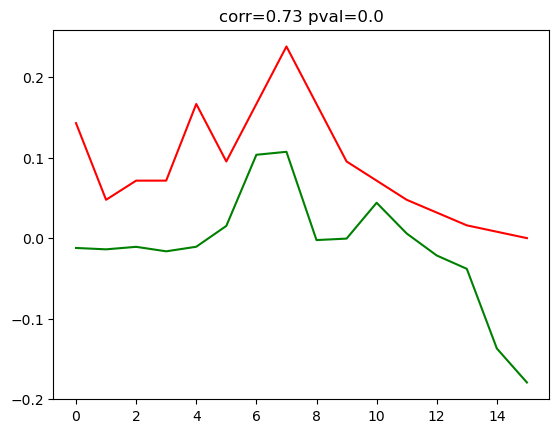

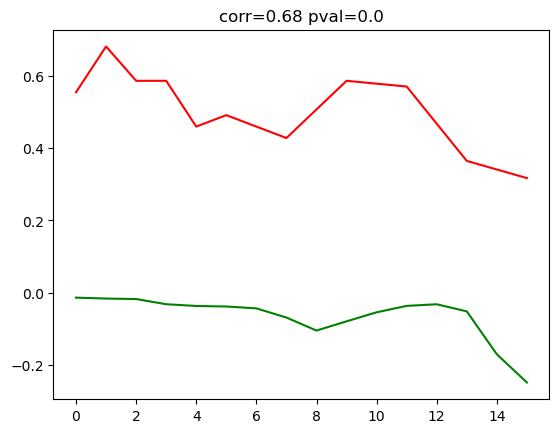

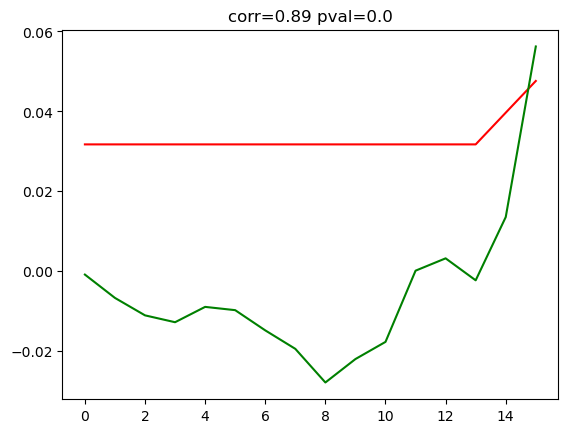

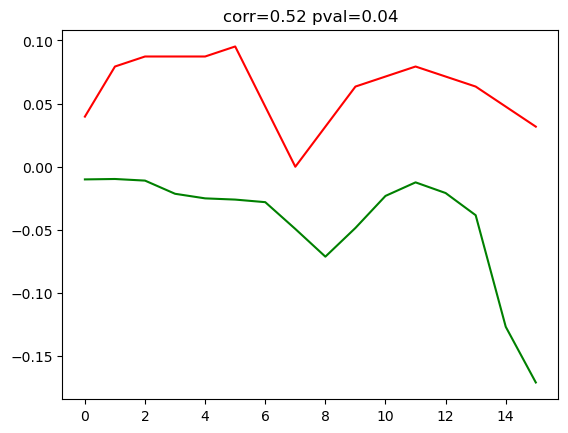

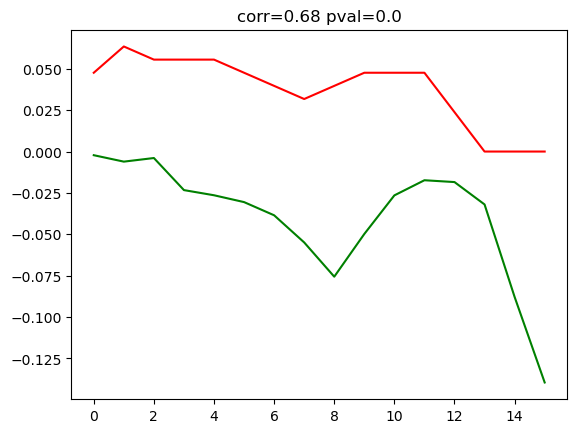

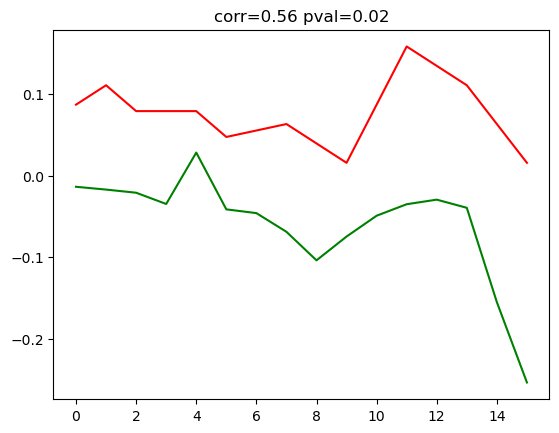

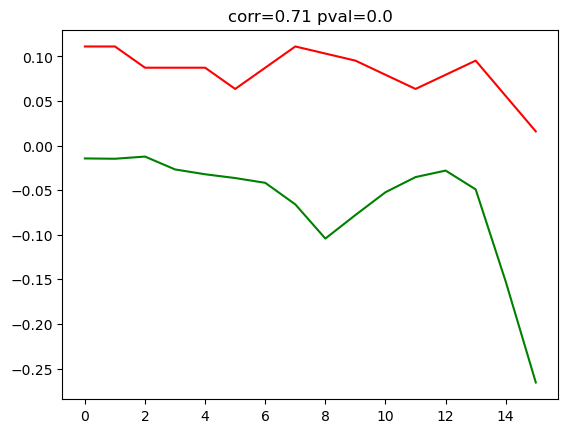

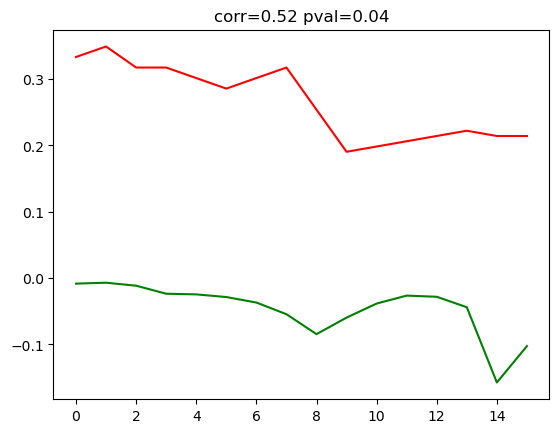

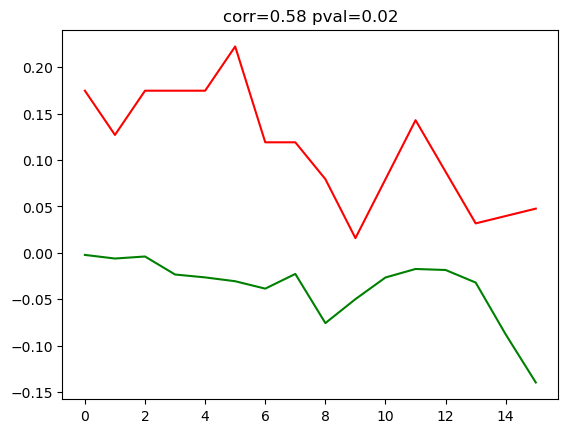

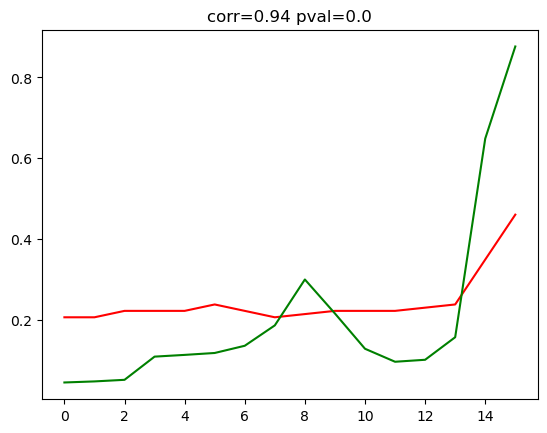

In [594]:
for i in range(len(significant_positive_corr)):
    if significant_positive_corr[i] == True:
        plt.figure()
        plt.plot(SAH1_bdi[i, :], c='red')
        plt.plot(pca_transformed[i, :], c='green')
        plt.title('corr='+str(np.round(corr_out[i], 2)) + ' pval='+str(np.round(pval_out[i],2)))

In [595]:
pca_transformed = np.zeros((X_SAH0.shape[0], X_SAH0.shape[2]))

for i in range(X_SAH0.shape[2]):
    pca = PCA(n_components=1, svd_solver='full')
    pca.fit(X_SAH0[:,:,i])
    pca_covid_severity = np.squeeze(pca.transform(X_SAH0[:,:,i]))
    pca_transformed[:,i] = pca_covid_severity

corr_out = []
pval_out = []

print(pca_transformed.shape)
print(SAH0.shape)

for i in range(X_SAH0.shape[0]):
    pearson_corr = stats.pearsonr(pca_transformed[i,:], SAH0_bdi[i,:])
    corr_out.append(pearson_corr[0])
    pval_out.append(pearson_corr[1])

df = pd.DataFrame({'corr':corr_out, 'pval':pval_out})
significant_positive_corr = (df['pval'] < 0.05) & (df['corr'] > 0).values
significant_negative_corr = (df['pval'] < 0.05) & (df['corr'] < 0).values
print(np.sum(significant_positive_corr))
print(np.sum(significant_negative_corr))

(45, 16)
(45, 29, 16)
1
1


# Synthetic control (need to check this but it would be interesting)

In [434]:
for i in range(SAH.shape[0]):
    if (SAH[i,:] == 0).all():
        print(i)

11
29
73
80
93
103
131
132
149
250
252
326
332
337
352
414
441
491
497
499
556
557
610
640
650
682
786
801
808
826
838
842
849
883
884
916
917
974
977
1007
1018
1085
1117
1131
1146


In [433]:
pca_transformed

array([[-0.11153564, -0.1116519 , -0.09696486, ..., -0.1797607 ,
        -0.15328225, -0.22719144],
       [-0.09349133, -0.09696044, -0.08946934, ..., -0.09290533,
        -0.08426244, -0.2134212 ],
       [-0.08243793, -0.08878852, -0.08166282, ...,  0.00108037,
        -0.00050075, -0.00040943],
       ...,
       [ 0.00949231,  0.0054844 , -0.047523  , ..., -0.17797314,
        -0.145383  , -0.08203538],
       [ 0.08944592,  0.14948118,  0.07907754, ..., -0.06325864,
        -0.04801435, -0.05857753],
       [-0.09633629, -0.09287202, -0.08489826, ..., -0.01377782,
         0.02268419,  0.17226504]])

In [401]:
big_five

['NEO_Neuroticism',
 'NEO_Extraversion',
 'NEO_Openness',
 'NEO_Agreeableness',
 'NEO_Conscientiousness',
 'Income',
 'Age']

In [340]:
personality = analysis.extract_personality(big_five)
print(personality.shape)
x = np.mean(personality[:,0,:], axis=1)
y = np.mean(personality[:,1,:], axis=1)
z = np.mean(personality[:,2,:], axis=1)

(1177, 3, 16)


In [350]:
x

array([0.54152815, 0.25972407, 0.86458333, ..., 0.05604499, 0.27140126,
       0.26619293])

In [353]:
c = np.asarray(c)

In [354]:

print(np.mean(x[c==1]))
print(np.std(x)/np.sqrt(len(x)-1))


0.39549336476683444
0.006488984390521196


In [355]:
print(np.mean(x[c==2]))
print(np.std(x)/np.sqrt(len(x)-1))

0.5397118101728724
0.006488984390521196


In [356]:
print(np.mean(x[c==3]))
print(np.std(x)/np.sqrt(len(x)-1))

0.43640561257691757
0.006488984390521196


In [357]:
print(np.mean(y[c==1]))
print(np.std(y)/np.sqrt(len(y)-1))
print(np.mean(y[c==2]))
print(np.std(y)/np.sqrt(len(y)-1))
print(np.mean(y[c==3]))
print(np.std(y)/np.sqrt(len(y)-1))

0.5348011715689842
0.005157603396391109
0.4073630850140367
0.005157603396391109
0.48151446349908694
0.005157603396391109


In [358]:
print(np.mean(z[c==1]))
print(np.std(z)/np.sqrt(len(z)-1))
print(np.mean(z[c==2]))
print(np.std(z)/np.sqrt(len(z)-1))
print(np.mean(z[c==3]))
print(np.std(z)/np.sqrt(len(z)-1))

0.5884860088144904
0.004749111694696637
0.5834566966672055
0.004749111694696637
0.5977029246086876
0.004749111694696637


In [347]:
print(np.mean(y))
print(np.std(y)/np.sqrt(len(y)-1))

0.4798552512164981
0.005157603396391109


In [348]:
print(np.mean(z))
print(np.std(z)/np.sqrt(len(z)-1))

0.5943097701410938
0.004749111694696637


In [329]:
personalities = analysis.extract_personality(big_five)

In [330]:
big_five

['NEO_Neuroticism', 'NEO_Extraversion', 'NEO_Openness']

In [331]:
personalities.shape

(1177, 3, 16)

In [332]:
df_personality = pd.DataFrame(columns=big_five, )

In [333]:
mean_personality_over_waves = np.mean(personalities, axis=0)

In [334]:
mean_personality_over_waves.shape

(3, 16)

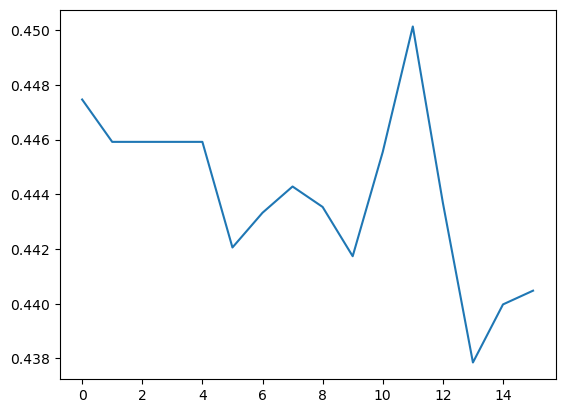

In [335]:
plt.plot(mean_personality_over_waves[0,:])

In [336]:
len(c)

1177

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(1177, 3, 16)
(1177, 16)


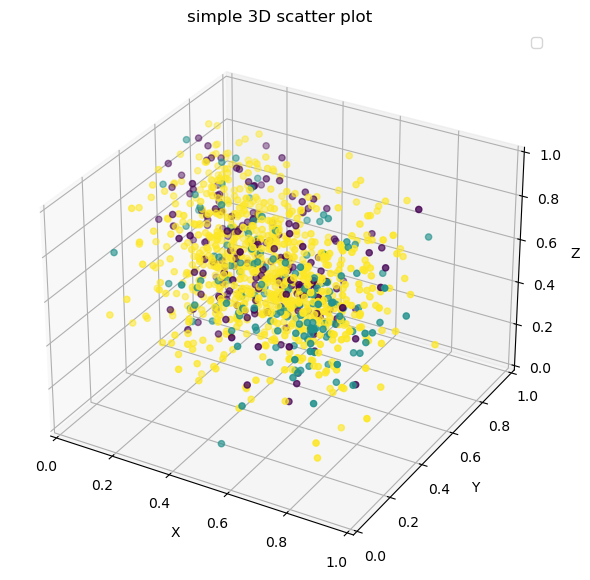

In [337]:
analysis = LongitudinalAnalysis()
analysis.plot_personality_3d(big_five, c)

In [192]:
before_sah, after_sah = analysis.compare_before_after_sah(analysis.data)

In [193]:
analysis.pearson_corr(before_sah, after_sah)

Ttest_indResult(statistic=1.265292584759173, pvalue=0.20578212057595188)

In [194]:
bdi_sah_corr = analysis.bdi_sah_corr()

/home/andy/anaconda3/envs/g/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [195]:
positive_indexes, negative_indexes = analysis.extract_significant_subjects(bdi_sah_corr)

In [196]:
before, after = analysis.compare_before_after_sah(analysis.data[positive_indexes, :, :])
analysis.pearson_corr(before, after)



Ttest_indResult(statistic=-11.592899283695031, pvalue=1.9987309644606047e-30)

In [197]:
before, after = analysis.compare_before_after_sah(analysis.data[negative_indexes, :, :])
analysis.pearson_corr(before, after)

Ttest_indResult(statistic=8.246699282089299, pvalue=2.5721258746343844e-16)

In [198]:
before, after = analysis.compare_before_after_sah(analysis.data[~(negative_indexes | positive_indexes), :, :])
analysis.pearson_corr(before, after)

Ttest_indResult(statistic=-0.0056569962948886205, pvalue=0.9954864789510974)

In [199]:
before, after = analysis.compare_before_after_sah(analysis.data[negative_indexes | positive_indexes, :, :])
analysis.pearson_corr(before, after)

Ttest_indResult(statistic=0.519163548428104, pvalue=0.6036674570454619)

In [200]:
before, after = analysis.compare_before_after_sah(analysis.data[positive_indexes, :, :])
analysis.pearson_corr(before, after)
print(np.mean(before))
print(np.mean(after))

0.12097368543789987
0.18402639428433218


In [201]:
before, after = analysis.compare_before_after_sah(analysis.data[negative_indexes, :, :])
analysis.pearson_corr(before, after)
print(np.mean(before))
print(np.mean(after))

0.3363684027214666
0.2633706314790238


In [202]:
before, after = analysis.compare_before_after_sah(analysis.data[~(negative_indexes | positive_indexes), :, :])
analysis.pearson_corr(before, after)
print(np.mean(before))
print(np.mean(after))

0.20424346619299644
0.2042623925101872


In [203]:
big_five = ["NEO_Neuroticism", 
"NEO_Extraversion", 
"NEO_Openness"]
#big_five = analysis.extract_personality(big_five)

In [204]:
big_five

['NEO_Neuroticism', 'NEO_Extraversion', 'NEO_Openness']

# testing for external data

In [3]:
external_data = pd.read_csv('../data/css_panel_2020-2022.tab', sep='\t')

/tmp/ipykernel_5900/3916520924.py:1: DtypeWarning: Columns (4,69,80,81,83,89,90,91,92,93,94,95,96,97,98,99,100,159,160,161,162,163,164,165,166,167,168) have mixed types. Specify dtype option on import or set low_memory=False.
  external_data = pd.read_csv('../data/css_panel_2020-2022.tab', sep='\t')


: 

: 

In [ ]:
external_data

record_id\twave_name\twave\tdate\tweek\tcovid\tcovidcontact\tcovidw\tcovidtest\tcovidwhen\tcovidwhen_2\tcovidexperience\tlongcovid_symp\tlongcovid_diag\tcovidexposure\tcovidtestjan\tcovidtestmarch\tlcfmob\tlcfcog\tlcfcar\tcircumstances1\tcircumstances2\tisolationstatus1\tisolationstatus2\tisolationstatus3\tisolationstatus6\tisolationstatus4\tisolationstatus5\tisolationstatus8\tisolationstatus9\tisolationstatus7\tisolation_new\tisolation_reason1\tisolation_reason2\tisolation_reason3\tisolation_reason4\tisolation_reason5\tisolation_reason6\tisolation_reason7\tleavinghome1\tleavinghome2\tleavinghome3\tleavinghome4\tleavinghome5\tleavinghome6\tleavinghome7\tleavinghome8\tleavinghome9\tleavinghome10\tleavinghome11\tleavinghome12\tleavinghome1_jan\tleavinghome2_jan\tleavinghome3_jan\tleavinghome4_jan\tleavinghome5_jan\tleavinghome6_jan\tleavinghome8_jan\tleavinghome9_jan\tleavinghome10_jan\tleavinghome11_jan\tleavinghome12_jan\ttier\tlife_diff\tlife_diff_lock\tdaysisolating\tdaysoutside\tdaysface\tdayscall\tsleep\tsmokechange\talcoholchange\tfoodchange_2\tdietchange_3\talcohol_repeated\tdietchangem\tfoodchangem\tsmokechangem\talcoholchangem\tsmoker_repeated\tonssat\tonsworth\tonshappy\tcovidknowledge\tfollowingisolation\tfollowingisolation_others\tconfidencegov\tconfidencegov_central\tconfidencegov_devolved\tconfidencehealth\tconfidenceessent\tadverse1\tadverse2\tadverse3\tadverse4\tadverse5\tadverse6\tadverse7\tadverse8\tadverse9\tadverse10\tphq1\tphq2\tphq3\tphq4\tphq5\tphq6\tphq7\tphq8\tphq9\tharm1\tharm2\tharm3\tphqextra\tstressorsminor1\tstressorsminor2\tstressorsminor3\tstressorsminor4\tstressorsminor5\tstressorsminor6\tstressorsminor7\tstressorsminor8\tstressorsminor9\tstressorsminor10\tstressorsminor11\tstressorsminor12\tstressorsminor13\tstressorsminor14\tstressorsminor15\tstressorsminor16\tstressorsminor17\tstressorsminor18\tstressorsminor19\tstressorsmajor1\tstressorsmajor2\tstressorsmajor3\tstressorsmajor4\tstressorsmajor5\tstressorsmajor6\tstressorsmajor7\tstressorsmajor8\tstressorsmajor9\tstressorsmajor10\tstressorsmajor11\tstressorsmajor12\tstressorsmajor13\tstressorsmajor14\tstressorsmajor15\tstressorsmajor16\tstressorsmajor17\tstressorsmajor18\tstressorsmajor19\tgad1\tgad2\tgad3\tgad4\tgad5\tgad6\tgad7\ttreatment1\ttreatment2\ttreatment3\ttreatment4\ttreatment5\ttreatment6\ttreatment7\ttreatment8\ttreatment9\ttreatment0\tsupp1\tsupp2\tsupp3\tsupp4\tsupp5\tsupp6\tsoc1\tsoc2\tsoc3\tsoc4\tacta1\tacta2\tacta3\tacta4\tacta5\tacta6\tacta7\tacta8\tactb1\tactb2\tactb3\tactb4\tactb5\tactb6\tactb7\tactb8\tactc1\tactc2\tactc3\tactc4\tactc5\tactc6\tactc7\tactc8\tactd0\tactd1\tactd2\tactd3\tactd4\tactd5\tactd6\tactd7\tactd8\tactd11\tactd9\tactd10\ttimeuse1\ttimeuse2\ttimeuse3\ttimeuse4\ttimeuse5\ttimeuse6\ttimeuse7\ttimeuse8\ttimeuse9\ttimeuse10\ttimeuse11\ttimeuse12\ttimeuse13\ttimeuse14\tacttime1\tacttime2\tacttime3\tacttime4\tacttime5\tacttime6\tacttime7\tacttime8\tacttime9\tacttime10\tacttime11\tacttime12\tacttime13\tacttime14\tfaith1\tfaith2\tfaith3\tfaith4\treligion1\treligion2\treligion3\treligion4\treligion5\treligion6\treligion7\treligion8\treligion9\treligattend\treligonline\tvol1\tvol2\tvol3\tvol4\tvol5\tvol6\tvol7\tvol8\tvol9\tvol10\tvol11\tvol12\tvol13\tvol14\tvol15\tvolunteeramount\tvolunteeramount_le\tvolunteeramount_le_2\tcontrol1\tcontrol2\tcontrol3\tcontrol8\tcontrol4\tcontrol5\tcontrol6\tcontrol7\tcontrol1_2021\tcontrol2_2021\tcontrol3_2021\tcontrol8_2021\tcontrol4_2021\tcontrol5_2021\tcontrol6_2021\tcontrol7_2021\tmissing_minor1\tmissing_minor2\tmissing_minor3\tmissing_minor4\tmissing_minor5\tmissing_minor6\tmissing_minor7\tmissing_minor8\tmissing_minor9\tmissing_minor10\tmissing_minor11\tmissing_minor12\tmissing_minor13\tmissing_major1\tmissing_major2\tmissing_major3\tmissing_major4\tmissing_major5\tmissing_major6\tmissing_major7\tmissing_major8\tmissing_major9\tmissing_major10\tmissing_major11\tmissing_major12\tmissing_major13\tafterlockdown1\tafterlockdown2\tafterlockdown3\tafterlockdown4\tafterlockdown5\t